In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, hamming_loss, precision_score,recall_score,f1_score
import shap
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr

def round_to_005(x):
    return round(x/0.05)*0.05
    

## Gene-disease DOE

In [2]:
ext_pred = True

drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    if True:
        drugs.loc[drugs[col] > 0, col] = 1
    if False:
        drugs.loc[drugs[col] == 0.5, col] = 1*0.732*0.548*0.580*0.911
        drugs.loc[drugs[col] == 1, col] = 1*0.732*0.548*0.580
        drugs.loc[drugs[col] == 2., col] = 1*0.732*0.548
        drugs.loc[drugs[col] == 3, col] = 1*0.732
        drugs.loc[drugs[col] == 4, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code','gene'],axis=1)

input = pd.read_pickle('./Training/input_extended.pkl')
input['ID'] = input['Code'] + '|' + input['gene']
input = input.drop(['Code','gene'],axis=1).dropna(thresh=20, axis=1).dropna(thresh=2,axis=0)

###

raresv_strat = ['genebass_sv_hclof_neg','genebass_sv_hclof_pos','genebass_sv_lclof',
                'genebass_sv_lof_0.5missense_neg','genebass_sv_lof_0.5missense_pos','genebass_sv_lof_missense_neg','genebass_sv_lof_missense_pos',
                'genebass_sv_gof_0.5missense_neg','genebass_sv_gof_0.5missense_pos','genebass_sv_gof_missense_neg','genebass_sv_gof_missense_pos',
                'finngen_sv_hclof', 'finngen_sv_lclof','finngen_sv_gof',
                'finngen_sv_other_missense', 'genebass_sv_other_0.5missense_neg','genebass_sv_other_0.5missense_pos','genebass_sv_other_missense_neg','genebass_sv_other_missense_pos', 'finngen_sv_other_0.5missense']
raresv = ['genebass_sv_hclof', 'genebass_sv_lclof', 'genebass_sv_lof_0.5missense','genebass_sv_lof_missense',
          'genebass_sv_gof_0.5missense', 'genebass_sv_gof_missense', 'genebass_sv_hcgof',
          'finngen_sv_hclof', 'finngen_sv_lclof','finngen_sv_gof',
          'genebass_sv_other_0.5missense', 'genebass_sv_other_missense', 'finngen_sv_other_0.5missense', 'finngen_sv_other_missense']
eqtl = ['locus2gene', 'panukbb_eqtl', 'finngen_eqtl', 'mvp_eqtl']
gb = ['genebass_gb_hclof_missense', 'genebass_gb_hclof','genebass_gb_hclof_lclof_missense',
      'jurgens_lof', 'jurgens_lof_0.5missense', 'jurgens_lof_0.8missense','jurgens_0.2missense', 'jurgens_0.5missense',
      'finngen_gb_lof']
otp_unique = ['eva_hclof', 'eva_lclof', 'eva_gof', 'impc_lof'] #'orphanet_g2p_lof', 'ot_gene_burden'
otp_only = ['eva_hclof','eva_lclof','eva_gof','impc_lof','locus2gene']
target = ['lof.oe_ci.upper_bin_decile'] # ,'Category', 'Nonspecific'

###

if ext_pred == True:
    ext = pd.read_pickle('./Training/input_extended_all_filtered.pkl')
    ext['ID'] = ext['Code'] + '|' + ext['gene']
    ext = ext.drop(['Code','gene'],axis=1).dropna(thresh=20, axis=1).dropna(thresh=3,axis=0)
    ext = ext.loc[ext['sources'] >= 1]
    ext['types'] = 0
    ext.loc[(ext[eqtl].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
    ext.loc[(ext[raresv].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
    ext.loc[(ext[gb].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
        
input['types'] = 0
input.loc[(input[eqtl].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
input.loc[(input[raresv].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
input.loc[(input[gb].abs() > 0.001).sum(axis=1) >= 1, 'types'] += 1
input.loc[input['types'] == 0, 'types_0'] = 1
input.loc[input['types'] == 1, 'types_1'] = 1
input.loc[input['types'] == 2, 'types_2'] = 1
input.loc[input['types'] == 3, 'types_3'] = 1

input['sources'] = (input[eqtl+raresv+gb+otp_unique].abs() > 0.001).sum(axis=1)
input.loc[input['sources'].between(0, 2), 'any_0'] = 1
input.loc[input['sources'].between(3, 5), 'any_3'] = 1
input.loc[input['sources'].between(6, 8), 'any_6'] = 1
input.loc[input['sources'] >= 9, 'any_9'] = 1
input.loc[(input[otp_only] != 0).sum(axis=1) >= 1, 'ot_1'] = 1

filters = input[['ID','any_0','any_3','any_6','any_9','ot_1',
                 'types_0','types_1','types_2','types_3']]

if True:
    sc = pd.concat([input[['ID','sources']],ext[['ID','sources']]]).drop_duplicates('ID')
    sc = sc.merge(pd.concat([input[['ID','types']],ext[['ID','types']]]).drop_duplicates('ID'), how='outer')
    sc.to_pickle('./Training/source_count.pkl')


### Tuning

In [ ]:
num_folds_outer=5
num_folds_inner=5

if True:
    model_names=['all']
    feature_names=[target+raresv+eqtl+gb+otp_unique]

param_grid={
 "max_depth":[5,6,7],
 "alpha":[0,1,5,10],
 "lambda":[1,5,10],
 "eta":[0.1,0.3],
 "gamma":[0,1,5,10]
}

results=[]
for i,j in zip(model_names,feature_names):
    print(i)
    data=pd.merge(input[['ID']+j],drugs,on="ID")
    X=data.drop(["ID","neg","other","pos"],axis=1)
    y=data[["neg","other","pos"]].values
    y_binary=(y>0).astype(int)
    ids=data["ID"].values
    outer_kf=KFold(n_splits=num_folds_outer,shuffle=True,random_state=42)
    fold_counter_outer=0
    for outer_train_idx,holdout_idx in outer_kf.split(X):
        fold_counter_outer+=1
        X_outer_train,X_holdout=X.iloc[outer_train_idx],X.iloc[holdout_idx]
        y_outer_train,y_holdout=y[outer_train_idx],y[holdout_idx]
        y_holdout_binary=y_binary[holdout_idx]
        ids_holdout=ids[holdout_idx]
        for md in param_grid["max_depth"]:
            for a in param_grid["alpha"]:
                for l in param_grid["lambda"]:
                    for e in param_grid["eta"]:
                        for g in param_grid["gamma"]:
                            inner_kf=KFold(n_splits=num_folds_inner,shuffle=True,random_state=42)
                            holdout_preds_all=[]
                            for inner_train_idx,val_idx in inner_kf.split(X_outer_train):
                                X_inner_train,X_val=X_outer_train.iloc[inner_train_idx],X_outer_train.iloc[val_idx]
                                y_inner_train,y_val=y_outer_train[inner_train_idx],y_outer_train[val_idx]
                                dtrain=xgb.DMatrix(X_inner_train,label=y_inner_train,enable_categorical=True)
                                dval=xgb.DMatrix(X_val,label=y_val,enable_categorical=True)
                                dholdout=xgb.DMatrix(X_holdout,enable_categorical=True)
                                params={
                                 "objective":"reg:logistic",
                                 "max_depth":md,
                                 "alpha":a,
                                 "lambda":l,
                                 "eta":e,
                                 "gamma":g,
                                 "min_child_weight":10,
                                 "nthread":12
                                }
                                model=xgb.train(params,dtrain,num_boost_round=2000,
                                 early_stopping_rounds=15,evals=[(dval,"eval")],verbose_eval=False)
                                preds_holdout=model.predict(dholdout).reshape(len(X_holdout),-1)
                                holdout_preds_all.append(preds_holdout)
                            holdout_preds_all=np.mean(np.stack(holdout_preds_all,axis=0),axis=0)
                            binary_preds=(holdout_preds_all>0.5).astype(int)
                            hl=hamming_loss(y_holdout_binary,binary_preds)
                            for c in range(y_holdout_binary.shape[1]):
                                auroc=roc_auc_score(y_holdout_binary[:,c],holdout_preds_all[:,c])
                                auprc=average_precision_score(y_holdout_binary[:,c],holdout_preds_all[:,c])
                                prop_pos=y_holdout_binary[:,c].mean()
                                results.append({
                                 "outer_fold":fold_counter_outer,
                                 "class":c,
                                 "max_depth":md,
                                 "alpha":a,
                                 "lambda":l,
                                 "eta":e,
                                 "gamma":g,
                                 "AUROC":auroc,
                                 "AUPRC":auprc,
                                 "proportion_positives":prop_pos,
                                 "hamming_loss":hl
                                })
                            print(f"Outer Fold {fold_counter_outer}, Params md={md}, alpha={a}, lambda={l}, eta={e}, gamma={g}, Hamming Loss={hl}")

results_df=pd.DataFrame(results)
results_df.to_pickle('./Training/Metrics/all_tuning.pkl')


In [77]:
hpt = pd.read_pickle('./Training/Metrics/all_tuning.pkl').groupby(['max_depth','alpha','lambda','eta','gamma'])[['AUROC','AUPRC']].mean()
hpt.sort_values('AUROC',ascending=False)[:20]

AUROC     AUPRC
max_depth alpha lambda eta gamma                    
7         5     1      0.1 0      0.768502  0.628675
          1     1      0.1 0      0.767747  0.628578
          5     5      0.1 0      0.767670  0.627921
                10     0.1 0      0.767326  0.627825
                1      0.3 0      0.767165  0.627005
                5      0.3 0      0.766875  0.626794
          1     5      0.1 0      0.766716  0.626618
6         5     1      0.1 0      0.766647  0.626765
7         1     1      0.3 0      0.766618  0.627423
          5     10     0.3 0      0.766199  0.626184
6         5     5      0.1 0      0.765387  0.624694
7         1     5      0.3 0      0.765273  0.625101
                10     0.1 0      0.765086  0.624118
                       0.3 0      0.764950  0.624213
6         5     5      0.3 0      0.764723  0.624634
7         0     1      0.1 0      0.764692  0.624389
6         5     1      0.3 0      0.764569  0.624334
                10     0.1 0      0.764327  0.623620
                       0.3 0      0.764251  0.623505
7         10    1      0.1 0      0.764180  0.623290

### Training

In [11]:
num_folds_outer = 8
num_folds_inner = 8
shap_enabled = True

if True:
    model_names = ['all','target','genetics','otp']
    feature_names = [target+raresv+eqtl+gb+otp_unique,target,raresv+eqtl+gb+otp_unique,otp_only]

if False:
    model_names = ['all']
    feature_names = [target+raresv+eqtl+gb+otp_unique]

for i,j in zip(model_names, feature_names):
    print(i)    

    data = pd.merge(input[['ID'] + j], drugs, on="ID")

    X = data.drop(["ID","neg","other","pos"], axis=1)
    y = data[["neg","other","pos"]].values    
    y_binary = (y > 0).astype(int)
    ids = data['ID'].values

    if (i in ['all']) & (ext_pred == True):
        X_ext = ext[['ID'] + j]
        X_ext = X_ext.loc[~X_ext['ID'].isin(data['ID'])]
        ids_ext = X_ext['ID'].values
        X_ext = X_ext.drop('ID',axis=1)
        dext = xgb.DMatrix(X_ext, enable_categorical=True)
        
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    ext_preds = []
    
    shap_neg = pd.DataFrame()
    shap_oth = pd.DataFrame()
    shap_pos = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        print(fold_counter_outer)
        fold_counter_outer += 1
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        
        holdout_preds_all = []
        ext_preds_all = []
        
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            #print(fold_counter_inner)
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":14
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
    
            # Save model
            # model.save_model(f"./Training/Models/{i}_outer{fold_counter_outer}_inner{fold_counter_inner}.json")

            if (i in ['all']) & (shap_enabled == True):
                if fold_counter_inner == 1:
                    explainer = shap.TreeExplainer(model)
                    explanation = explainer(dholdout)
                    ex_neg = pd.DataFrame(explanation[:,:,0].values, columns=X.columns)
                    ex_neg['ID'] = ids_holdout
                    shap_neg = pd.concat([shap_neg,ex_neg])
                    ex_oth = pd.DataFrame(explanation[:,:,1].values, columns=X.columns)
                    ex_oth['ID'] = ids_holdout
                    shap_oth = pd.concat([shap_oth,ex_oth])
                    ex_pos = pd.DataFrame(explanation[:,:,2].values, columns=X.columns)
                    ex_pos['ID'] = ids_holdout
                    shap_pos = pd.concat([shap_pos,ex_pos])

            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)

            if (i in ['all']) & (ext_pred == True):
                preds_ext = model.predict(dext)
                preds_ext = preds_ext.reshape(len(X_ext), -1)
                ext_preds_all.append(preds_ext)           
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        if (i in ['all']) & (ext_pred == True):
            ext_preds_all = np.mean(np.stack(ext_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_neg": holdout_preds_all[:,0],
            "pred_other": holdout_preds_all[:,1],
            "pred_pos": holdout_preds_all[:,2]
        })
        all_preds.append(fold_df)

        if (i in ['all']) & (ext_pred == True):
            fold_df = pd.DataFrame({
                "ID": ids_ext,
                "pred_neg": ext_preds_all[:,0],
                "pred_other": ext_preds_all[:,1],
                "pred_pos": ext_preds_all[:,2]
            })
            ext_preds.append(fold_df)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/{i}_holdout_predictions.csv", index=False)

    if (i in ['all']) & (ext_pred == True):
        final_preds = pd.concat(ext_preds, axis=0)
        final_preds = final_preds.groupby("ID").mean().reset_index()
        final_preds.to_csv(f"./Training/Predictions/{i}_ext_predictions.csv", index=False)

    if (i in ['all']) & (shap_enabled == True):
        shap_neg = shap_neg.groupby('ID').mean().reset_index()
        shap_neg.to_pickle(f'./Training/SHAP/{i}_shap_neg.pkl')
        shap_oth = shap_oth.groupby('ID').mean().reset_index()
        shap_oth.to_pickle(f'./Training/SHAP/{i}_shap_oth.pkl')
        shap_pos = shap_pos.groupby('ID').mean().reset_index()
        shap_pos.to_pickle(f'./Training/SHAP/{i}_shap_pos.pkl')
        

all
0
Class 0: AUROC=0.6331286159437939, AUPRC=0.7817886097771903, Proportion positives=0.6796587487453998
Class 1: AUROC=0.6246443213146524, AUPRC=0.2781653027302857, Proportion positives=0.18049514887922383
Class 2: AUROC=0.6576651329138832, AUPRC=0.3583170123676027, Proportion positives=0.226497156239545
Hamming Loss=0.23982379837180773
1
Class 0: AUROC=0.6339346880339094, AUPRC=0.7825156817546404, Proportion positives=0.6835061893609903
Class 1: AUROC=0.6460436506275016, AUPRC=0.29756129239775175, Proportion positives=0.17497490799598528
Class 2: AUROC=0.6585878500598077, AUPRC=0.3605317163935135, Proportion positives=0.22816995650719304
Hamming Loss=0.23798371807739488
2
Class 0: AUROC=0.6276231203532898, AUPRC=0.7677694680802924, Proportion positives=0.6724657075945132
Class 1: AUROC=0.6201889401406062, AUPRC=0.2723330880457029, Proportion positives=0.17815322850451656
Class 2: AUROC=0.6611276554510949, AUPRC=0.38162978122869123, Proportion positives=0.23937771830043492
Hamming L

### SHAP

In [7]:
i = 'all'
shap_neg = pd.read_pickle(f'./Training/SHAP/{i}_shap_neg.pkl')
shap_pos = pd.read_pickle(f'./Training/SHAP/{i}_shap_pos.pkl')
shap_oth = pd.read_pickle(f'./Training/SHAP/{i}_shap_oth.pkl')

fv = input[shap_neg.columns]
fv = shap_neg[['ID']].merge(fv)

shap_neg = shap_neg.drop('ID', axis=1)
shap_pos = shap_pos.drop('ID', axis=1)
shap_oth = shap_oth.drop('ID', axis=1)
fv = fv.drop('ID', axis=1)

# Function to compute Spearman correlations
def compute_correlations(shap_data, fv_data):
    correlations = {}
    for col in shap_data.columns:
        if pd.api.types.is_numeric_dtype(fv_data[col]):
            mask = ~(shap_data[col].isna() | fv_data[col].isna())
            if mask.any():
                correlations[col] = spearmanr(fv_data.loc[mask, col], shap_data.loc[mask, col])[0]
    return correlations

# Function to compute SHAP absolute mean for all values and only for nonzero/non-NaN values in fv
def compute_shap_stats(shap_data, fv_data, label):
    correlations = compute_correlations(shap_data, fv_data)
    shap_values = []
    
    for col in shap_data.columns:
        all_mean = shap_data[col].abs().mean()  # Mean over all values
        
        mask = ~(fv_data[col].isna() | (fv_data[col] == 0))  # Ignore NaN and zero values in fv
        filtered_mean = shap_data.loc[mask, col].abs().mean() if mask.any() else None  # Mean over filtered values

        shap_values.append((col, all_mean, filtered_mean))

    shap_stats = pd.DataFrame(shap_values, columns=['feature', label, f'{label}_nonzero_nonNaN'])
    shap_corr = pd.DataFrame(list(correlations.items()), columns=['feature', f'{label}_corr'])
    
    return shap_stats.merge(shap_corr, how='left')

# Compute SHAP statistics for neg, pos, and other
sn = compute_shap_stats(shap_neg, fv, 'neg')
sp = compute_shap_stats(shap_pos, fv, 'pos')
so = compute_shap_stats(shap_oth, fv, 'other')

# Merge results
sa = sn.merge(sp, on='feature').merge(so, on='feature')
sa['average'] = sa[['neg', 'other', 'pos']].mean(axis=1)
sa['average_nonzero_nonNaN'] = sa[['neg_nonzero_nonNaN', 'other_nonzero_nonNaN', 'pos_nonzero_nonNaN']].mean(axis=1)

# Assign categories
sa.loc[sa['feature'].isin(raresv), 'category'] = 'Rare variants'
sa.loc[sa['feature'].isin(eqtl), 'category'] = 'eQTL'
sa.loc[sa['feature'].isin(gb), 'category'] = 'Gene burden'
sa.loc[sa['feature'].isin(target), 'category'] = 'Covariates'
sa.loc[sa['feature'].isin(otp_unique), 'category'] = 'Open Targets'

sa = sa.sort_values('average',ascending=False)
sa.to_excel('./Supplemental tables/gene_disease_fi.xlsx', index=False)


### Precision-recall plots

In [18]:
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    drugs.loc[drugs[col]>0,col]=1
drugs['ID']=drugs['Code']+'|'+drugs['gene']
drugs_gene = drugs.drop('Code',axis=1)
drugs=drugs.drop(['Code','gene'],axis=1)

pred = pd.read_csv(f'./Training/Predictions/all_holdout_predictions.csv').merge(drugs)


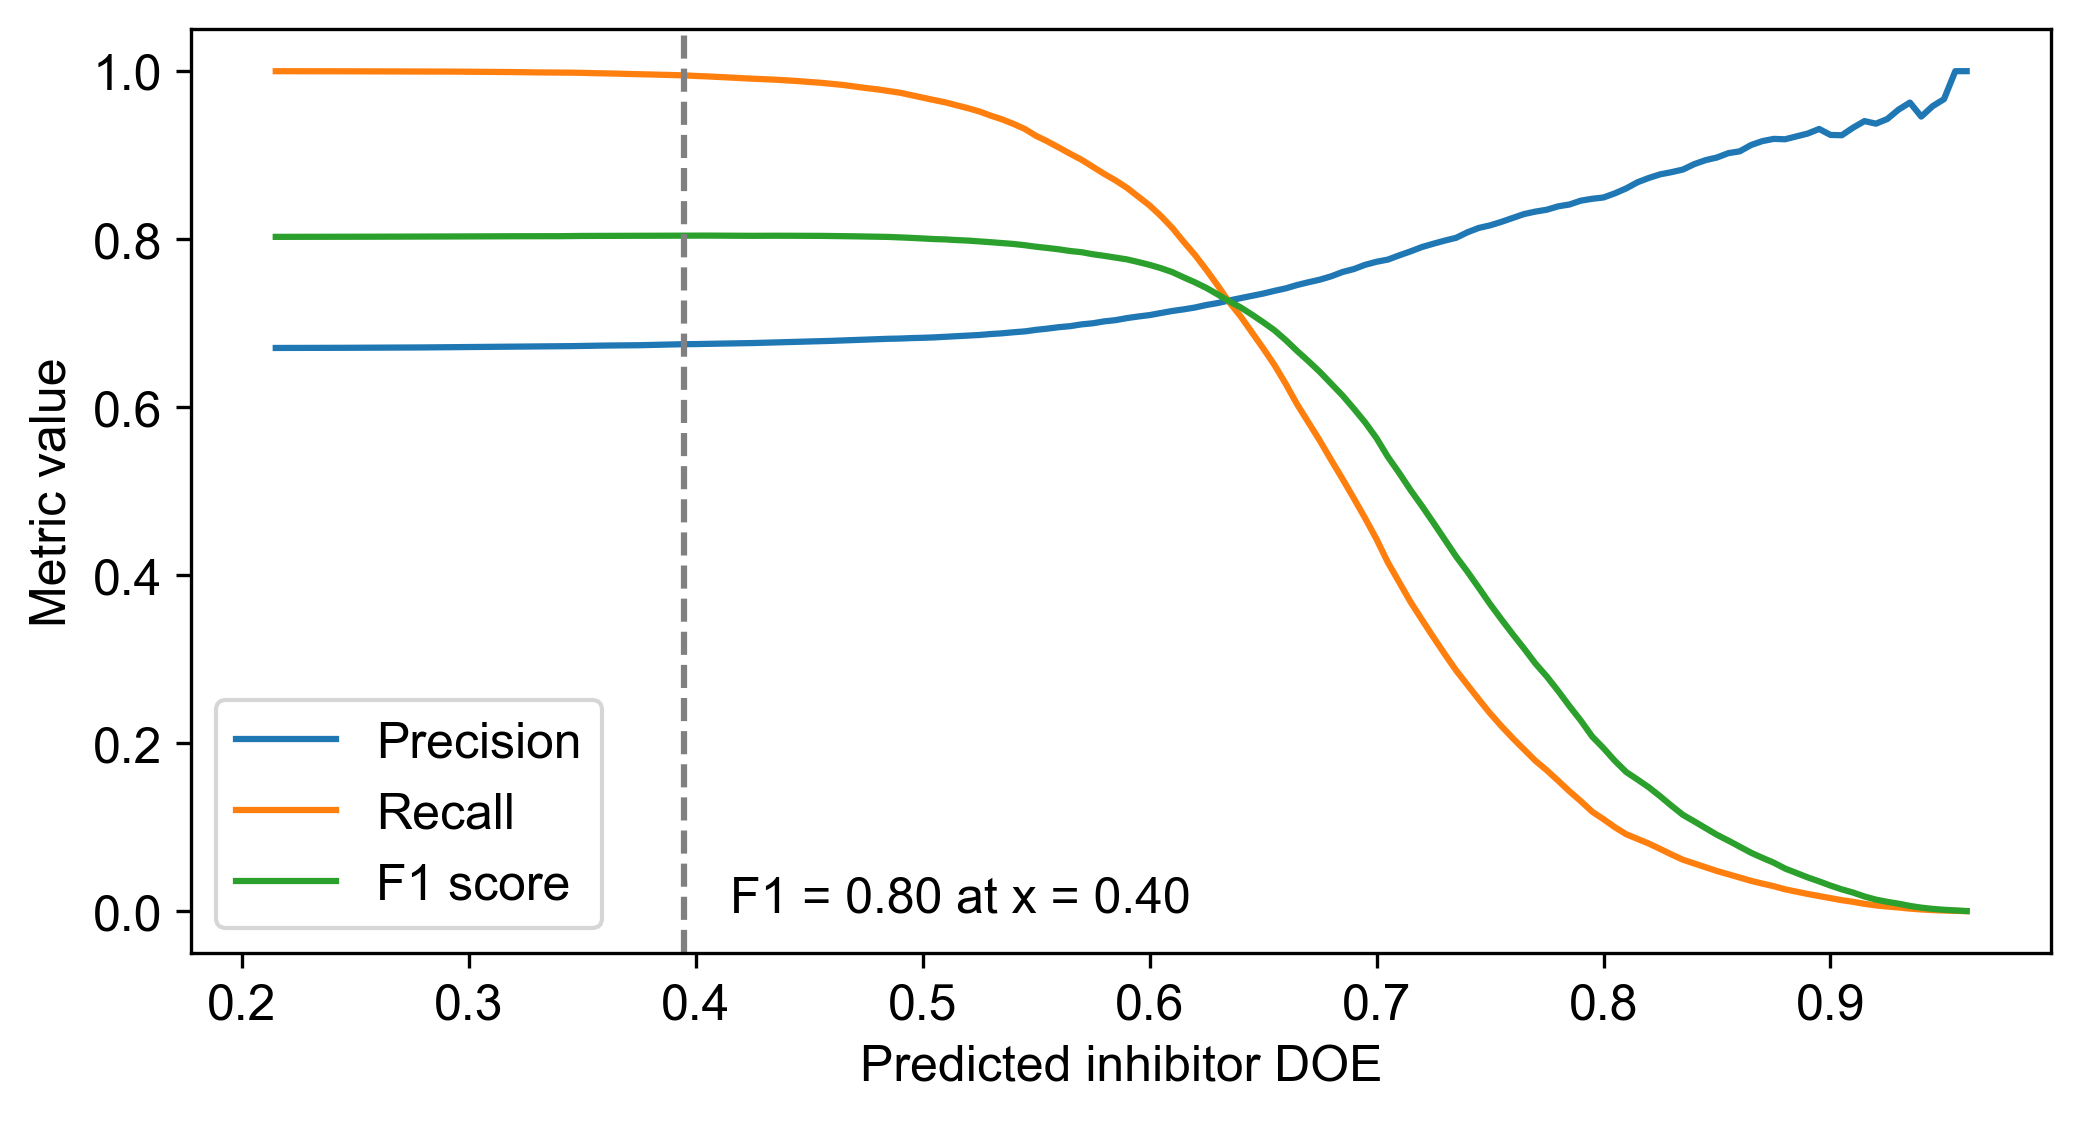

In [21]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_neg']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['neg'],b,zero_division=0)
        r=recall_score(pred['neg'],b,zero_division=0)
        f=f1_score(pred['neg'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0))
plt.legend(title='')
plt.xlabel('Predicted inhibitor DOE')
plt.ylabel('Metric value')
plt.show()


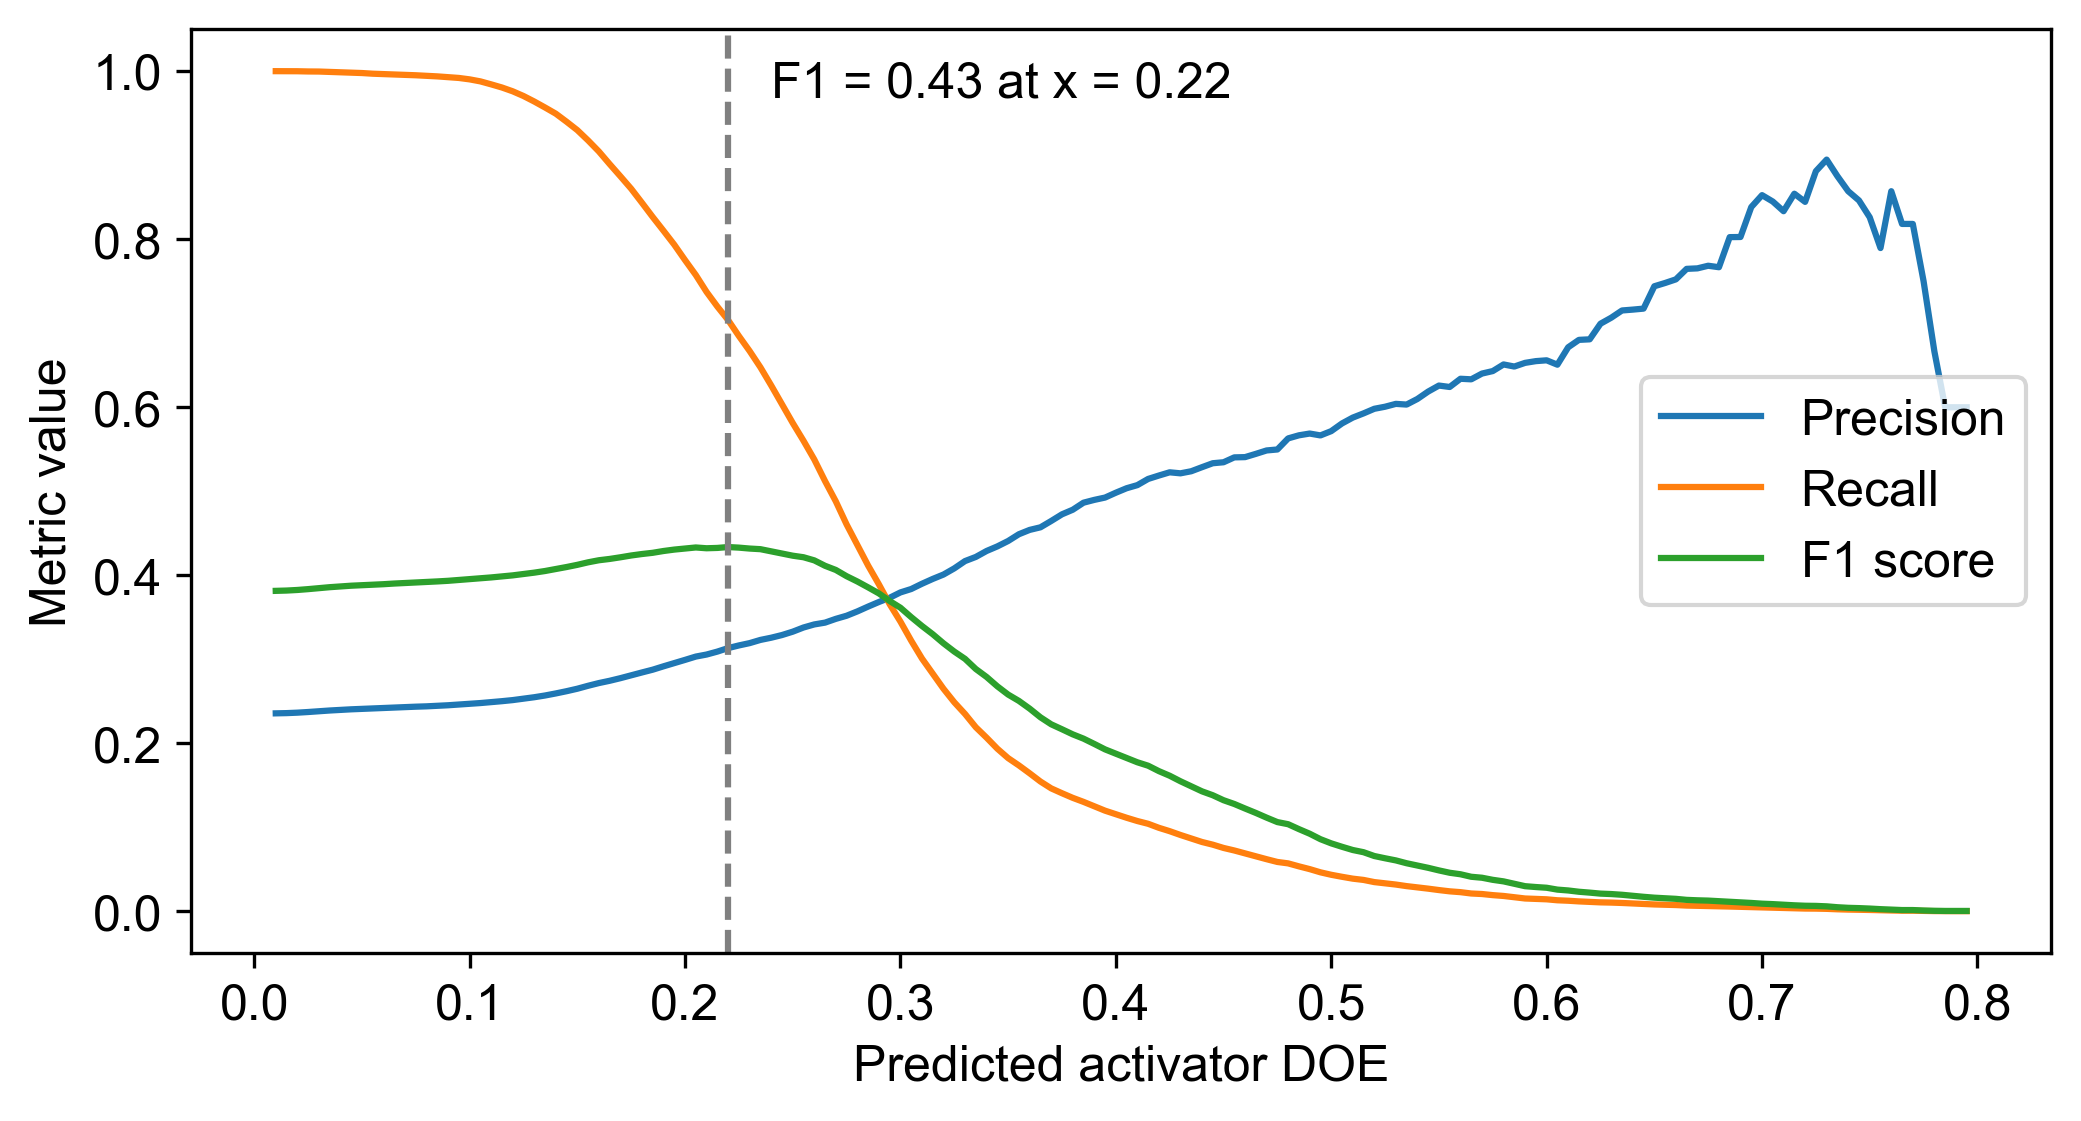

In [25]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_pos']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['pos'],b,zero_division=0)
        r=recall_score(pred['pos'],b,zero_division=0)
        f=f1_score(pred['pos'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='', loc='center right')
plt.xlabel('Predicted activator DOE')
plt.ylabel('Metric value')
plt.show()


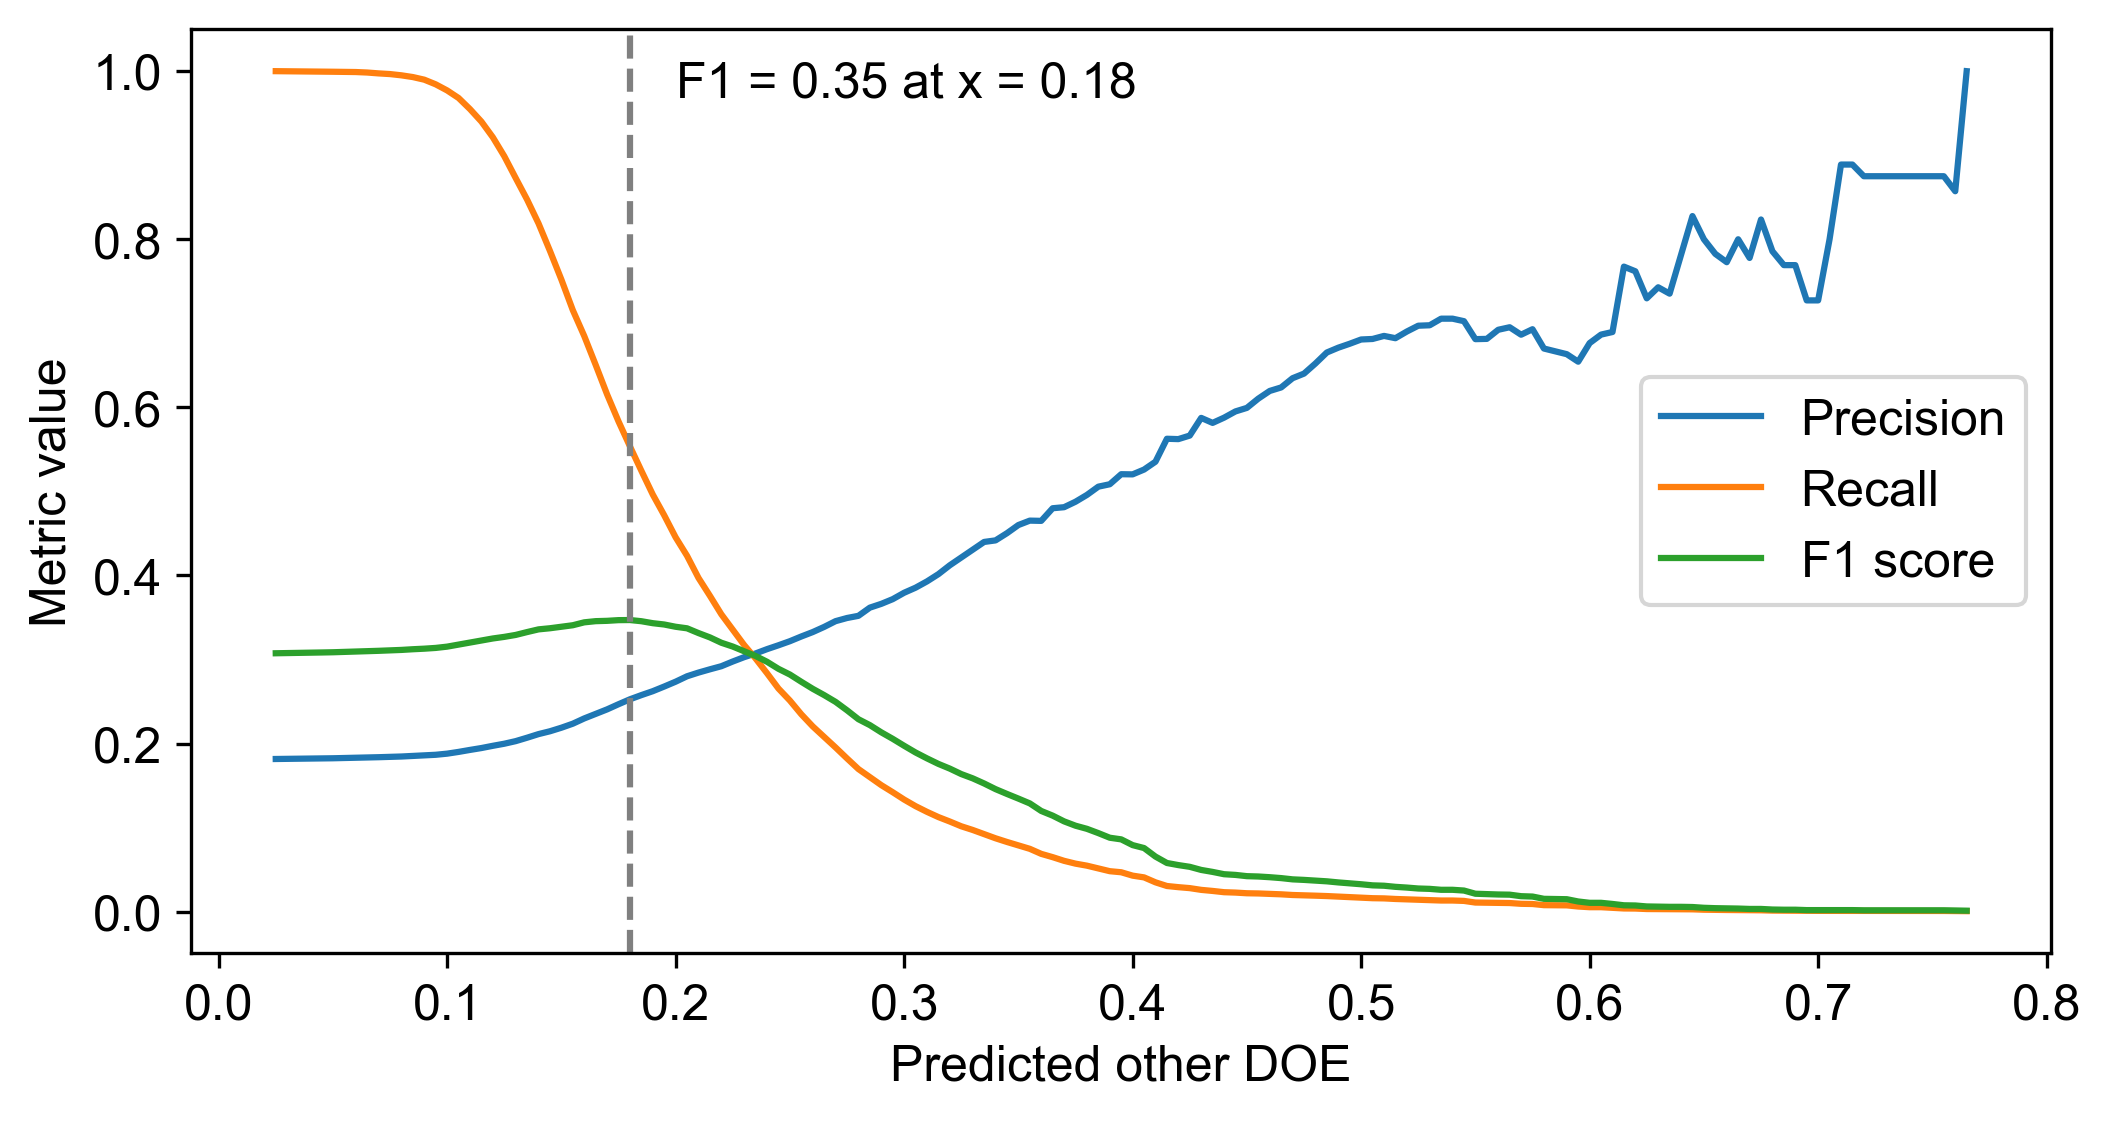

In [23]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_other']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['other'],b,zero_division=0)
        r=recall_score(pred['other'],b,zero_division=0)
        f=f1_score(pred['other'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted other DOE')
plt.ylabel('Metric value')
plt.show()


### Calculating metrics

In [3]:
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    drugs.loc[drugs[col]>0,col]=1
drugs['ID']=drugs['Code']+'|'+drugs['gene']
drugs_gene = drugs.drop('Code',axis=1)
drugs=drugs.drop(['Code','gene'],axis=1)

model_names=['doe','all','target','genetics']
metrics=pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    if i == 'doe':
        data=pd.read_csv(f'./Training/Predictions/doe_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
        data=data.merge(drugs_gene).drop('gene',axis=1).merge(filters)
    else:
        data=pd.read_csv(f'./Training/Predictions/{i}_holdout_predictions.csv').merge(drugs).merge(filters)
    for subset in ['all','any_0','any_3','any_6','any_9',
                   'types_0','types_1','types_2','types_3']:
        try:
            if subset != 'all':
                res = data.loc[data[subset] == 1].drop_duplicates('ID')
            else:
                res = data.copy()
            res[['neg_bin','other_bin','pos_bin']] = (res[['neg','other','pos']]>0).astype(int)
            y_true=res[['neg_bin','other_bin','pos_bin']].values
            y_score=res[['pred_neg','pred_other','pred_pos']].values
            boot=bootstrap_all_metrics(y_true,y_score,50)
            new_records=[]
            for k,(m,l,h) in boot.items():
                new_records.append({'subset':subset,'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h,'nonzero':len(res)})
            metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)
        except:
            continue

metrics.to_pickle('./Training/Metrics/pheno.pkl')


In [4]:
metrics = pd.read_pickle('./Training/Metrics/pheno.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'doe':'Gene-level DOE',
                                         'target':'LOEUF decile',
                                         'genetics':'Genetic data'})
metrics['model'] = pd.Categorical(metrics['model'], ['LOEUF decile','Genetic data','All features','Gene-level DOE'])

###

drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    if True:
        drugs.loc[drugs[col] > 0, col] = 1
    if False:
        drugs.loc[drugs[col] == 0.5, col] = 1*0.732*0.548*0.580*0.911
        drugs.loc[drugs[col] == 1, col] = 1*0.732*0.548*0.580
        drugs.loc[drugs[col] == 2., col] = 1*0.732*0.548
        drugs.loc[drugs[col] == 3, col] = 1*0.732
        drugs.loc[drugs[col] == 4, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code','gene'],axis=1)

input = pd.read_pickle('./Training/input_extended.pkl')
input['ID'] = input['Code'] + '|' + input['gene']
input = input.drop(['Code','gene'],axis=1)
input = input.dropna(thresh=20, axis=1)
input = input.dropna(thresh=2,axis=0)

data = drugs.merge(input, on='ID')
n_ids = data['ID'].nunique()
n_neg = int(data['neg'].sum())
n_other = int(data['other'].sum())
n_pos = int(data['pos'].sum())


In [7]:
table = metrics.copy()
table = table.loc[table['subset'] == 'all']
table.loc[table['metric'].str.contains('neg'), 'outcome'] = 'Inhibitor'
table.loc[table['metric'].str.contains('other'), 'outcome'] = 'Other'
table.loc[table['metric'].str.contains('pos'), 'outcome'] = 'Activator'
table.loc[table['metric'].str.contains('macro'), 'outcome'] = 'Macro-average'
table.loc[table['metric'].str.contains('micro'), 'outcome'] = 'Micro-average'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['outcome'] = pd.Categorical(table['outcome'], ['Activator','Inhibitor','Other','Macro-average','Micro-average'])

table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]

table


/tmp/ipykernel_3203220/2827951552.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()


metric,outcome,model,AUROC,AUPRC,Brier score
0,Activator,LOEUF decile,0.592 (0.586-0.598),0.303 (0.296-0.312),0.176 (0.175-0.178)
1,Activator,Genetic data,0.585 (0.58-0.59),0.29 (0.284-0.297),0.177 (0.175-0.179)
2,Activator,All features,0.66 (0.655-0.665),0.372 (0.363-0.38),0.169 (0.167-0.171)
3,Activator,Gene-level DOE,0.847 (0.843-0.851),0.596 (0.587-0.604),0.147 (0.144-0.149)
4,Inhibitor,LOEUF decile,0.555 (0.55-0.559),0.702 (0.696-0.706),0.219 (0.218-0.22)
5,Inhibitor,Genetic data,0.59 (0.586-0.595),0.746 (0.741-0.75),0.216 (0.214-0.217)
6,Inhibitor,All features,0.634 (0.629-0.638),0.773 (0.769-0.777),0.21 (0.209-0.211)
7,Inhibitor,Gene-level DOE,0.672 (0.667-0.677),0.795 (0.791-0.8),0.233 (0.23-0.235)
8,Other,LOEUF decile,0.55 (0.542-0.558),0.21 (0.204-0.216),0.148 (0.146-0.15)
9,Other,Genetic data,0.59 (0.585-0.597),0.247 (0.242-0.253),0.146 (0.144-0.148)


Text(0, 0.5, 'AUROC')

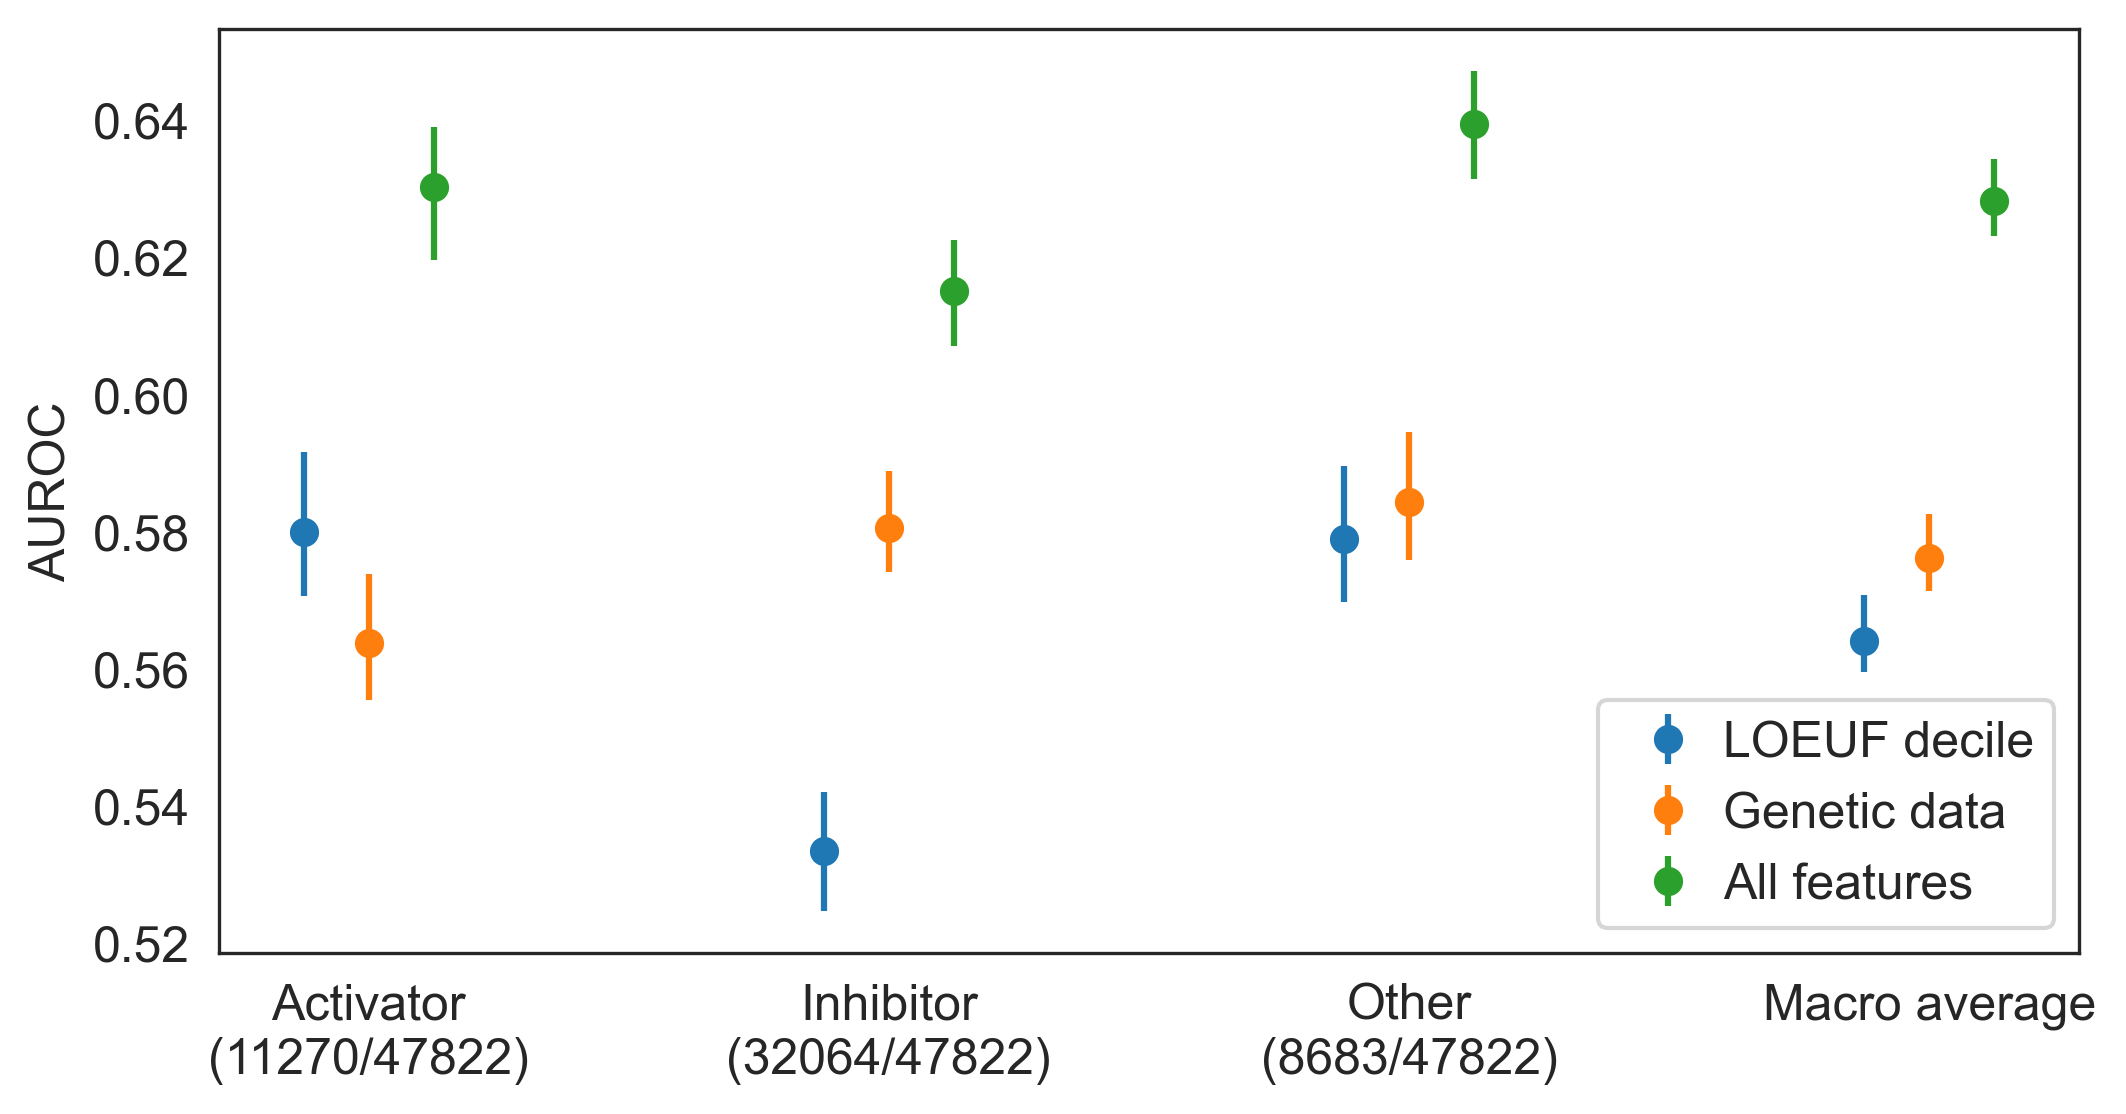

In [50]:
res = metrics.copy()
res = res.loc[res['model'] != 'Gene-level DOE']
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['subset'] == 'any_0']
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auroc_other':f'Other\n({n_other}/{n_ids})',
                                   'auroc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=1, loc='lower right', columnspacing=0.1, handletextpad=0.1)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
#plt.ylim([0.56,0.84])
plt.xlabel('')
plt.ylabel('AUROC')


Text(0, 0.5, 'AUPRC')

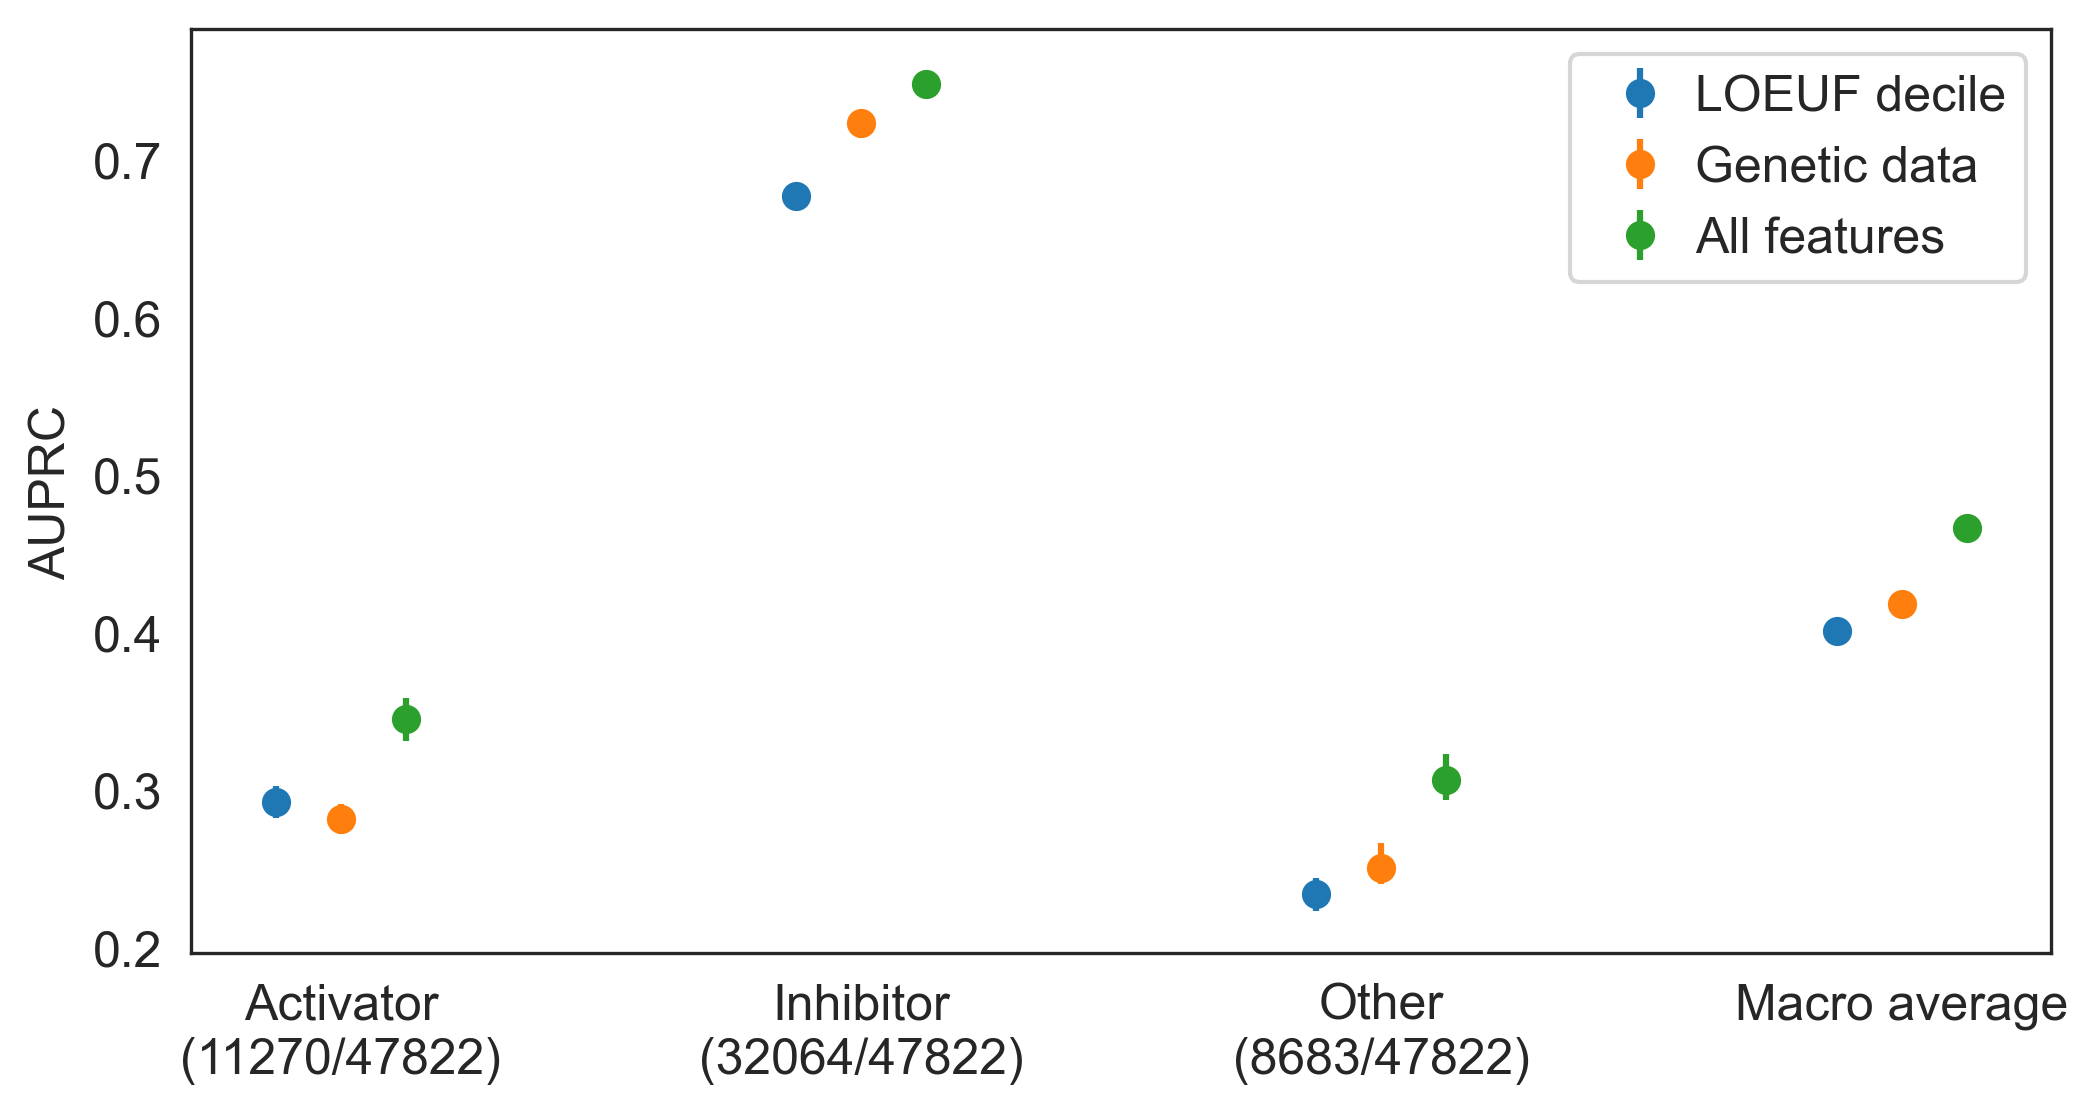

In [51]:
res = metrics.copy()
res = res.loc[res['model'] != 'Gene-level DOE']
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['subset'] == 'any_0']
res = res.loc[res['metric'].str.contains('auprc')]
res['metric'] = res['metric'].map({'auprc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auprc_other':f'Other\n({n_other}/{n_ids})',
                                   'auprc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auprc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=1, loc='upper right', columnspacing=0.1, handletextpad=0.1)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUPRC')


/tmp/ipykernel_3679069/1591645264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['fc'] = pdf['subset'].map({'all':'All','any_0':'0-2','any_3':'3-5','any_6':'6-8','any_9':'≥ 9'})
/tmp/ipykernel_3679069/1591645264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['fc'] = pd.Categorical(pdf['fc'], ['All','0-2','3-5','6-8','≥ 9'])


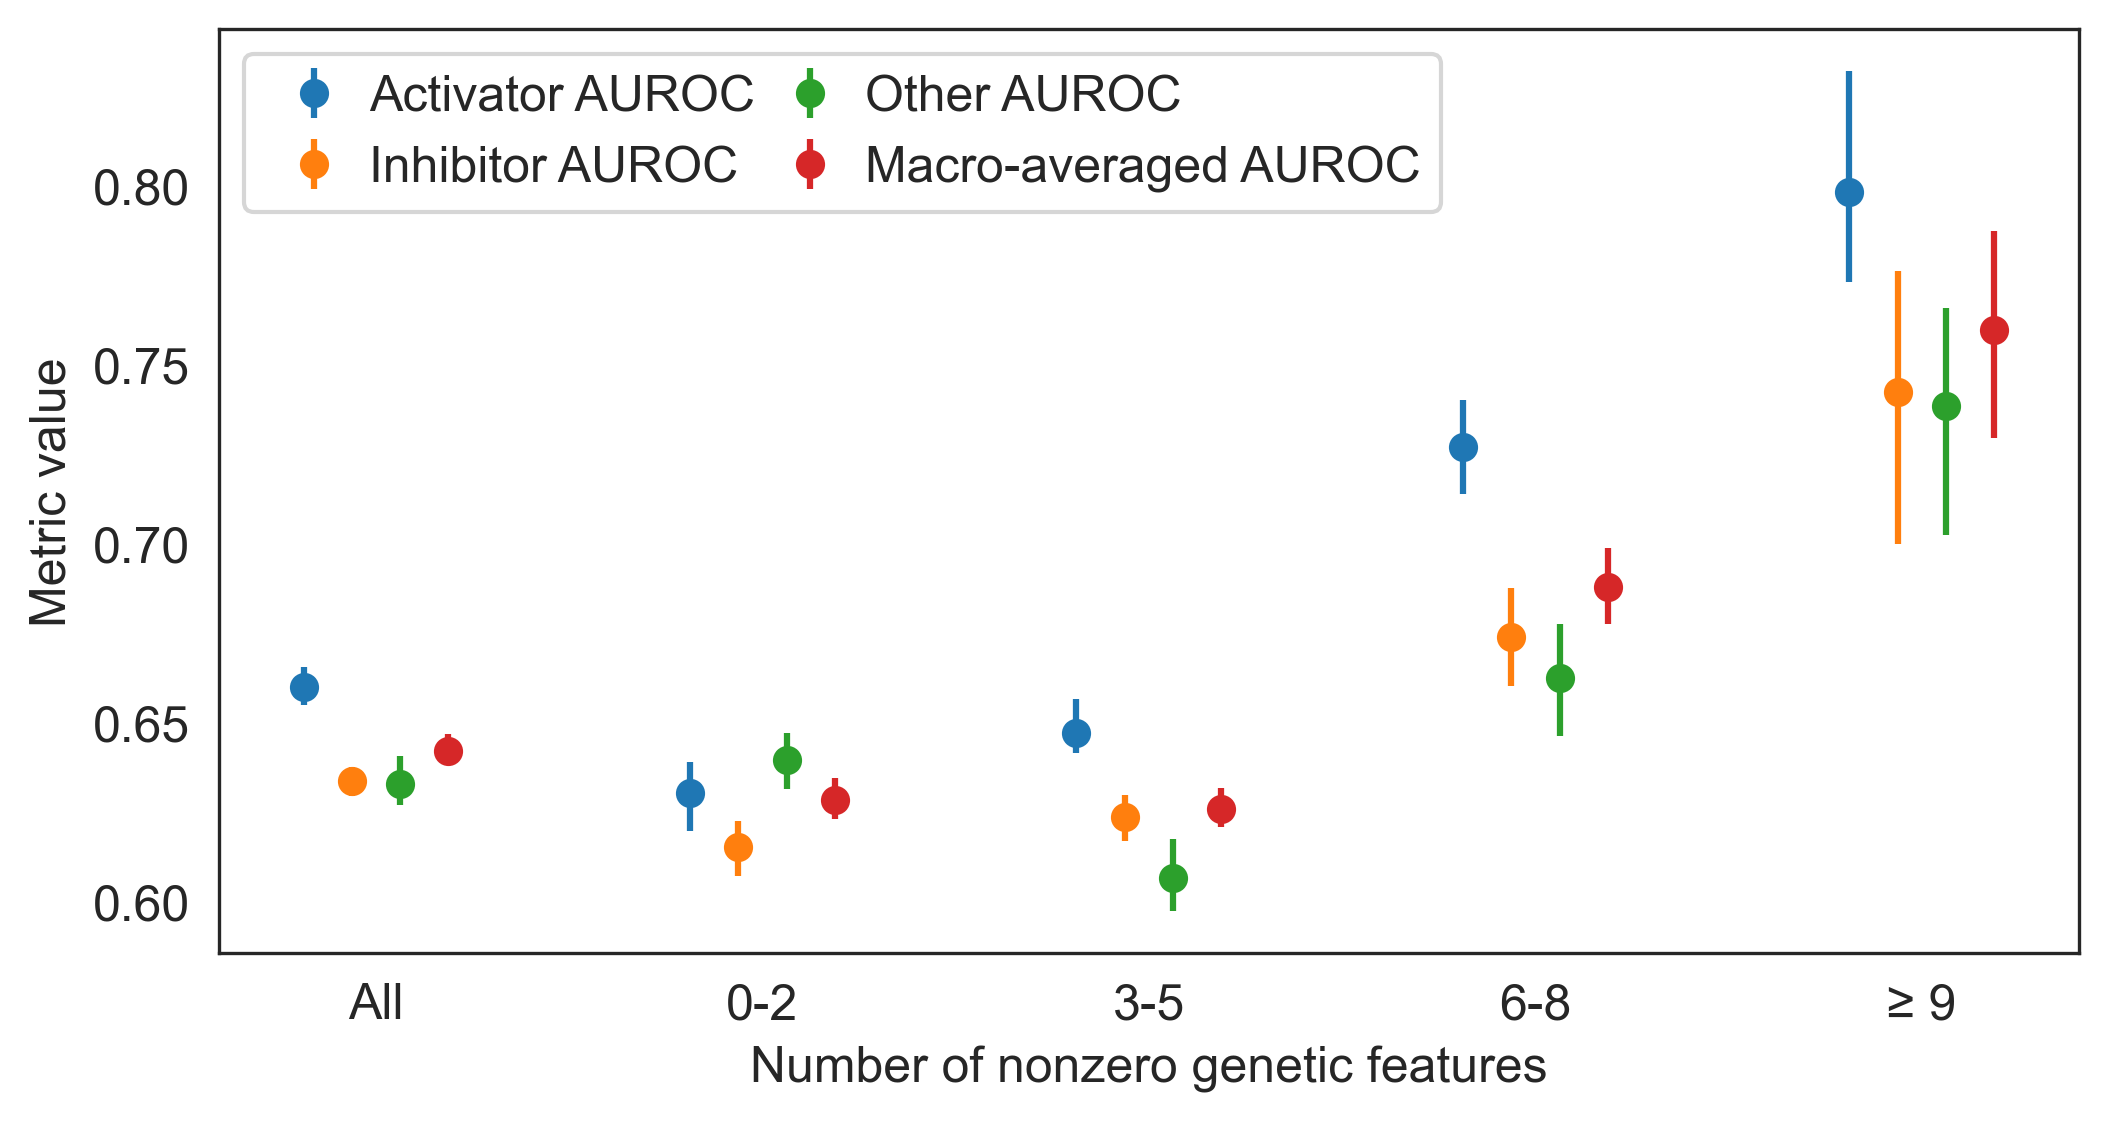

In [52]:
metrics = pd.read_pickle('./Training/Metrics/pheno.pkl')
pdf = metrics.loc[metrics['model'] == 'all']
pdf['fc'] = pdf['subset'].map({'all':'All','any_0':'0-2','any_3':'3-5','any_6':'6-8','any_9':'≥ 9'})
pdf['fc'] = pd.Categorical(pdf['fc'], ['All','0-2','3-5','6-8','≥ 9'])
pdf = pdf.loc[pdf['metric'].isin(['auroc_macro','auroc_neg','auroc_other','auroc_pos'])]
pdf['metric'] = pdf['metric'].map({'auroc_macro':'Macro-averaged AUROC',
                                   'auroc_neg':'Inhibitor AUROC',
                                   'auroc_other':'Other AUROC',
                                   'auroc_pos':'Activator AUROC'})
pdf['metric'] = pd.Categorical(pdf['metric'], ['Activator AUROC','Inhibitor AUROC','Other AUROC',
                                               'Macro-averaged AUROC'])
pdf = pdf.dropna(subset='fc').sort_values(['fc','metric'])

###

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,4), dpi=300)

fc_categories = list(pdf['fc'].unique())  # Preserve order of unique fc values
fc_mapping = {fc: i for i, fc in enumerate(fc_categories)}  # Map strings to indices

metrics = pdf['metric'].unique()
offset = 0.125 
x_positions = range(len(fc_categories))  # Numeric x positions for the categorical values

for i, metric in enumerate(metrics):
    subset = pdf[pdf['metric'] == metric]
    
    # Convert categorical 'fc' to numeric positions and apply dodging
    metric_positions = [fc_mapping[x] + (i - len(metrics) / 2 + 0.5) * offset for x in subset['fc']]
    
    ax.errorbar(metric_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=metric)

ax.set_xticks(x_positions)
ax.set_xticklabels(fc_categories)  # Keep original string labels
ax.legend(title='', ncols=2, loc='upper left', columnspacing=0.1, handletextpad=0.1)

plt.xlabel('Number of nonzero genetic features')
plt.ylabel('Metric value')

plt.show()


/tmp/ipykernel_3679069/4265025435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['fc'] = pdf['subset'].map({'all':'All','types_1':'1','types_2':'2','types_3':'3'})
/tmp/ipykernel_3679069/4265025435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['fc'] = pd.Categorical(pdf['fc'], ['All','1','2','3'])


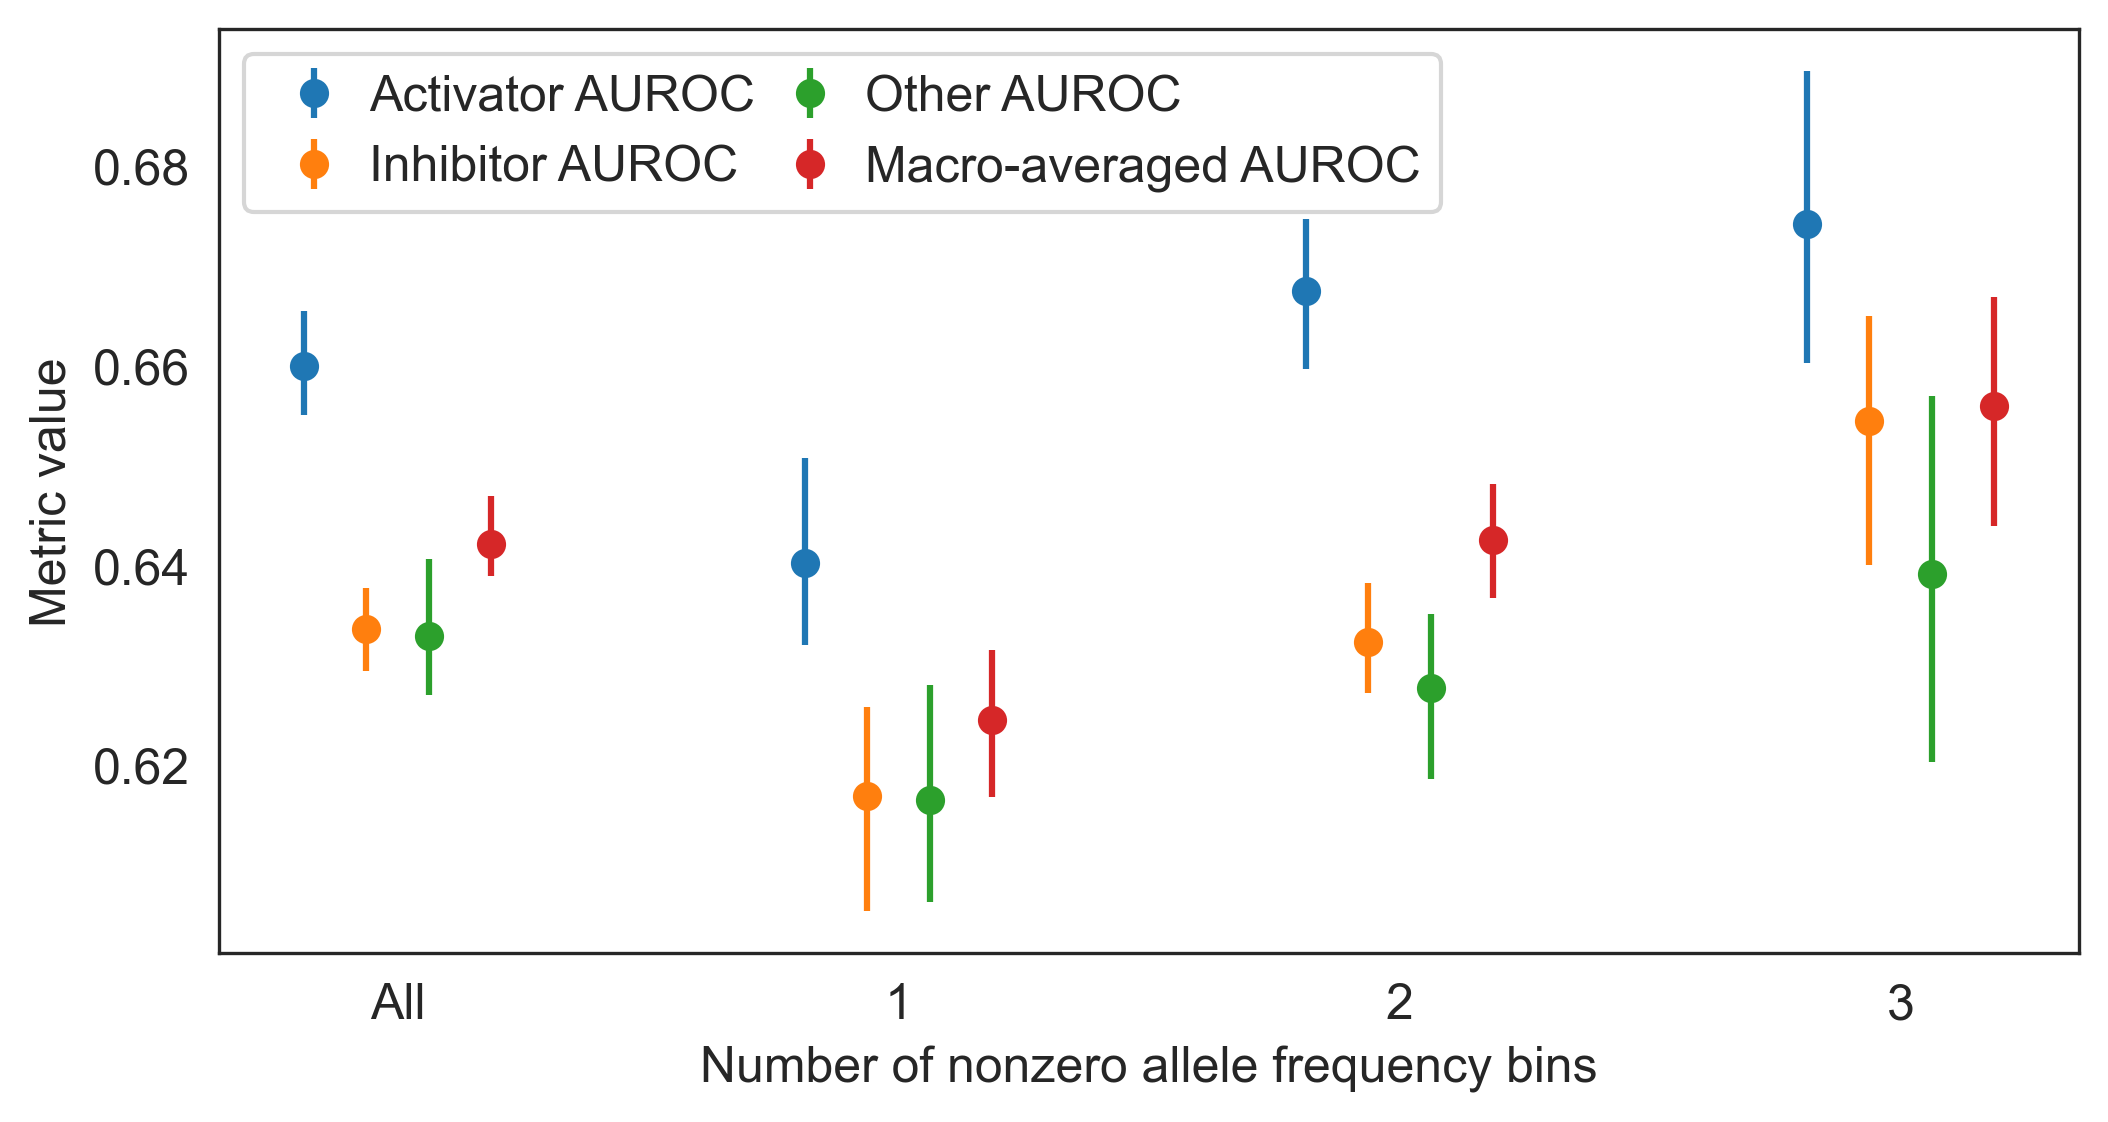

In [41]:
metrics = pd.read_pickle('./Training/Metrics/pheno.pkl')
pdf = metrics.loc[metrics['model'] == 'all']
pdf['fc'] = pdf['subset'].map({'all':'All','types_1':'1','types_2':'2','types_3':'3'})
pdf['fc'] = pd.Categorical(pdf['fc'], ['All','1','2','3'])
pdf = pdf.loc[pdf['metric'].isin(['auroc_macro','auroc_neg','auroc_other','auroc_pos'])]
pdf['metric'] = pdf['metric'].map({'auroc_macro':'Macro-averaged AUROC',
                                   'auroc_neg':'Inhibitor AUROC',
                                   'auroc_other':'Other AUROC',
                                   'auroc_pos':'Activator AUROC'})
pdf['metric'] = pd.Categorical(pdf['metric'], ['Activator AUROC','Inhibitor AUROC','Other AUROC',
                                               'Macro-averaged AUROC'])
pdf = pdf.dropna(subset='fc').sort_values(['fc','metric'])

###

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,4), dpi=300)

fc_categories = list(pdf['fc'].unique())  # Preserve order of unique fc values
fc_mapping = {fc: i for i, fc in enumerate(fc_categories)}  # Map strings to indices

metrics = pdf['metric'].unique()
offset = 0.125 
x_positions = range(len(fc_categories))  # Numeric x positions for the categorical values

for i, metric in enumerate(metrics):
    subset = pdf[pdf['metric'] == metric]
    
    # Convert categorical 'fc' to numeric positions and apply dodging
    metric_positions = [fc_mapping[x] + (i - len(metrics) / 2 + 0.5) * offset for x in subset['fc']]
    
    ax.errorbar(metric_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=metric)

ax.set_xticks(x_positions)
ax.set_xticklabels(fc_categories)  # Keep original string labels
ax.legend(title='', ncols=2, loc='upper left', columnspacing=0.1, handletextpad=0.1)

plt.xlabel('Number of nonzero allele frequency bins')
plt.ylabel('Metric value')

plt.show()


In [41]:
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    drugs.loc[drugs[col]>0,col]=1
drugs['ID']=drugs['Code']+'|'+drugs['gene']
drugs=drugs.drop(['Code','gene'],axis=1)

data=pd.read_csv(f'./Training/Predictions/all_holdout_predictions.csv').merge(drugs)

melt_data = pd.DataFrame({
    "pred": data["pred_neg"].apply(round_to_005).tolist() + 
            data["pred_pos"].apply(round_to_005).tolist() + 
            data["pred_other"].apply(round_to_005).tolist(),
    "true": data["neg"].tolist() + 
            data["pos"].tolist() + 
            data["other"].tolist(),
    "hue": ["neg"] * len(data) + ["pos"] * len(data) + ["other"] * len(data)
})

calibration_data = melt_data.groupby(["pred", "hue"]).agg(
    proportion_true=("true", "mean"),
    count=("true", "size")).reset_index()
calibration_data = calibration_data[calibration_data["count"] >= 10]
calibration_data['hue'] = calibration_data['hue'].map({'other':'Other','pos':'Activator','neg':'Inhibitor'})
calibration_data['hue'] = pd.Categorical(calibration_data['hue'], ['Activator','Inhibitor','Other'])


Text(0, 0.5, 'True proportion')

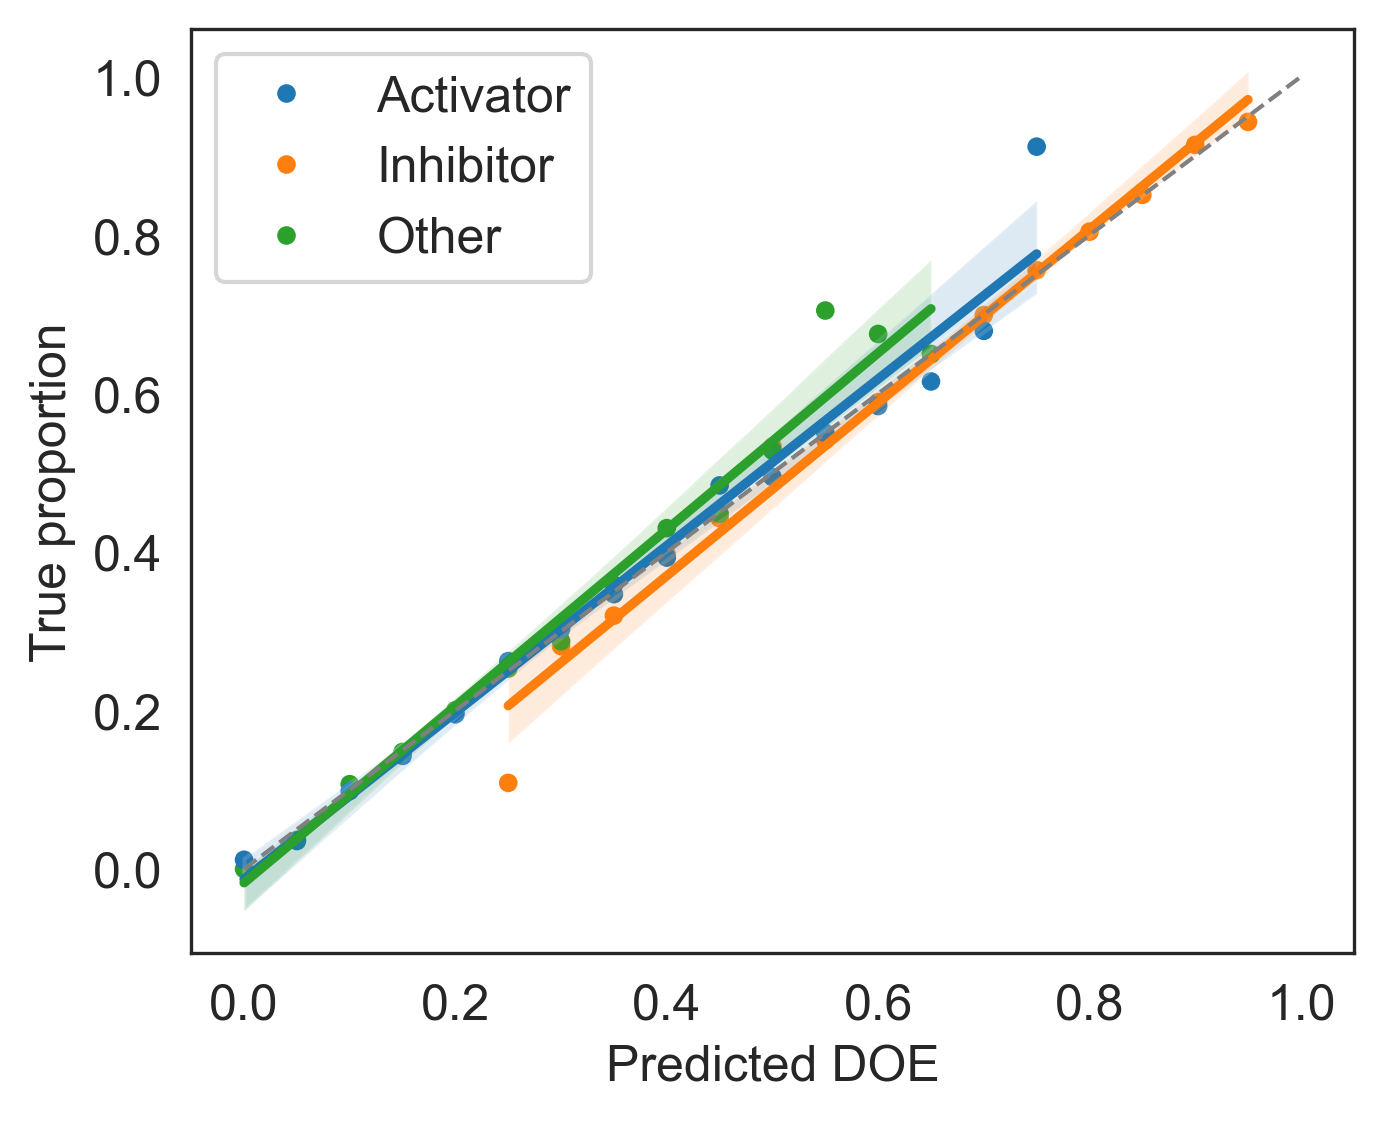

In [42]:
sns.set_style('white')
plt.figure(figsize=(5,4), dpi=300)

sns.scatterplot(data=calibration_data,x='pred',y='proportion_true',hue='hue',edgecolor='none',s=20)
for h,c in zip(['Activator','Inhibitor','Other'],sns.color_palette()[:3]):
    subset=calibration_data[calibration_data['hue']==h]
    sns.regplot(data=subset,x='pred',y='proportion_true',scatter=False,color=c,label=None)
plt.plot([0,1],[0,1],'--',c='gray',lw=1)
plt.legend(title='')
plt.xlabel('Predicted DOE')
plt.ylabel('True proportion')


In [9]:
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    drugs.loc[drugs[col]>0,col]=1
drugs['ID']=drugs['Code']+'|'+drugs['gene']
drugs_gene = drugs.drop('Code',axis=1)
drugs=drugs.drop(['Code','gene'],axis=1)

model_names=['all','otp']
metrics=pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_macro','brier_micro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    data=pd.read_csv(f'./Training/Predictions/{i}_holdout_predictions.csv').merge(drugs).merge(filters)
    for subset in ['all','ot_1']:
        if subset != 'all':
            res = data.loc[data[subset] == 1].drop_duplicates('ID')
        else:
            res = data.copy()
        res[['neg_bin','other_bin','pos_bin']] = (res[['neg','other','pos']]>0).astype(int)
        y_true=res[['neg_bin','other_bin','pos_bin']].values
        y_score=res[['pred_neg','pred_other','pred_pos']].values
        boot=bootstrap_all_metrics(y_true,y_score,100)
        new_records=[]
        for k,(m,l,h) in boot.items():
            new_records.append({'subset':subset,'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h,'nonzero':len(res)})
        metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/pheno_ot_compare.pkl')


In [25]:
metrics = pd.read_pickle('./Training/Metrics/pheno.pkl')
metrics = pd.concat([metrics,pd.read_pickle('./Training/Metrics/pheno_ot_compare.pkl')])
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'doe':'Gene-level DOE',
                                         'target':'LOEUF decile',
                                         'genetics':'Genetic data',
                                         'otp':'Only OTP data'})
metrics['model'] = pd.Categorical(metrics['model'], ['Only OTP data','LOEUF decile','Genetic data',
                                                     'All features','Gene-level DOE'])
metrics = metrics.loc[metrics['subset'] != 'types_0']
metrics = metrics.loc[~(metrics['subset'].isin(['any_0','any_3','any_6','any_9','types_0','types_1','types_2','types_3']) &
              (metrics['model'] != 'All features'))]
metrics['subset'] = metrics['subset'].map({'all':'All','ot_1':'≥ 1 OTP feature(s) nonzero','any_0':'0-2 genetic features nonzero',
                                           'any_3':'3-5 genetic features nonzero','any_6':'6-8 genetic features nonzero',
                                           'any_9':'≥ 9 genetic features nonzero','types_1':'1 allele frequency bin nonzero',
                                           'types_2':'2 allele frequency bins nonzero','types_3':'3 allele frequency bins nonzero'})
metrics['subset'] = pd.Categorical(metrics['subset'],['All','0-2 genetic features nonzero','3-5 genetic features nonzero',
                                                      '6-8 genetic features nonzero','≥ 9 genetic features nonzero',
                                                      '1 allele frequency bin nonzero','2 allele frequency bins nonzero',
                                                      '3 allele frequency bins nonzero','≥ 1 OTP feature(s) nonzero'])


In [27]:
table = metrics.copy()
table.loc[table['metric'].str.contains('neg'), 'outcome'] = 'Inhibitor'
table.loc[table['metric'].str.contains('other'), 'outcome'] = 'Other'
table.loc[table['metric'].str.contains('pos'), 'outcome'] = 'Activator'
table.loc[table['metric'].str.contains('macro'), 'outcome'] = 'Macro-average'
table.loc[table['metric'].str.contains('micro'), 'outcome'] = 'Micro-average'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['outcome'] = pd.Categorical(table['outcome'], ['Activator','Inhibitor','Other','Macro-average','Micro-average'])

table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['subset','outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['subset','outcome','model','AUROC','AUPRC','Brier score']]

table.to_excel('./Supplemental tables/gene_disease_metrics.xlsx', index=False)


/tmp/ipykernel_3203220/2114579041.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = pd.pivot_table(table, index=['subset','outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()


In [66]:
gda = pd.read_pickle('./OT/Final/gene_direction_all.pkl')
gda = gda.loc[(gda['neg'] == 1) & (gda['pos'] == 1)]['gene']

# Load and preprocess drug data
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg', 'other', 'pos']:
    drugs.loc[drugs[col] > 0, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code', 'gene'], axis=1)

# Load predictions
data = pd.read_csv(f'./Training/Predictions/all_holdout_predictions.csv').merge(drugs)
data['gene'] = data['ID'].str.split('|').str[1]

doe = pd.read_csv(f'./Training/Predictions/doe_all_holdout_predictions.csv')
doe = doe.set_axis(['gene', 'doe_neg', 'doe_other', 'doe_pos'], axis=1)
data = data.merge(doe)

# Compute averaged predictions
data['avg_neg'] = data[['pred_neg', 'doe_neg']].mean(axis=1)
data['avg_pos'] = data[['pred_pos', 'doe_pos']].mean(axis=1)
data['avg_other'] = data[['pred_other', 'doe_other']].mean(axis=1)

# Define bootstrapping function
def bootstrap_all_metrics(y_true, y_score, n_boot):
    np.random.seed(42)
    out = {f'auroc_{c}': [] for c in ['neg', 'other', 'pos']}
    out.update({f'auprc_{c}': [] for c in ['neg', 'other', 'pos']})
    for x in ['auroc_micro', 'auroc_macro', 'auprc_micro', 'auprc_macro', 'hamming']:
        out[x] = []
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt, ys = y_true[idx], y_score[idx]
        for i, c in enumerate(['neg', 'other', 'pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:, i], ys[:, i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:, i], ys[:, i]))
        out['auroc_micro'].append(roc_auc_score(yt, ys, average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt, ys, average='macro'))
        out['auprc_micro'].append(average_precision_score(yt, ys, average='micro'))
        out['auprc_macro'].append(average_precision_score(yt, ys, average='macro'))
        out['hamming'].append(hamming_loss(yt, (ys >= 0.5).astype(int)))
    return {k: (np.mean(v), np.percentile(v, 2.5), np.percentile(v, 97.5)) for k, v in out.items()}

# Initialize metrics storage
metrics = pd.DataFrame()

for subset in ['bd','all']:
    if subset == 'all':
        td = data.copy()
    else:
        td = data.loc[data['gene'].isin(gda)]
    for model in ['doe', 'pred', 'avg']:
        y_true = td[['neg', 'other', 'pos']].values
        y_score = td[[f'{model}_neg', f'{model}_other', f'{model}_pos']].values
    
        boot = bootstrap_all_metrics(y_true, y_score, 100)
        new_records = []
        for k, (m, l, h) in boot.items():
            new_records.append({'subset': subset, 'model': model, 'metric': k, 'mean': m, 'ci_low': l, 'ci_high': h})
        metrics = pd.concat([metrics, pd.DataFrame(new_records)], ignore_index=True)

# Save and display the results
metrics.to_pickle('./Training/Metrics/comp_metrics.pkl')


Text(0, 0.5, 'AUROC')

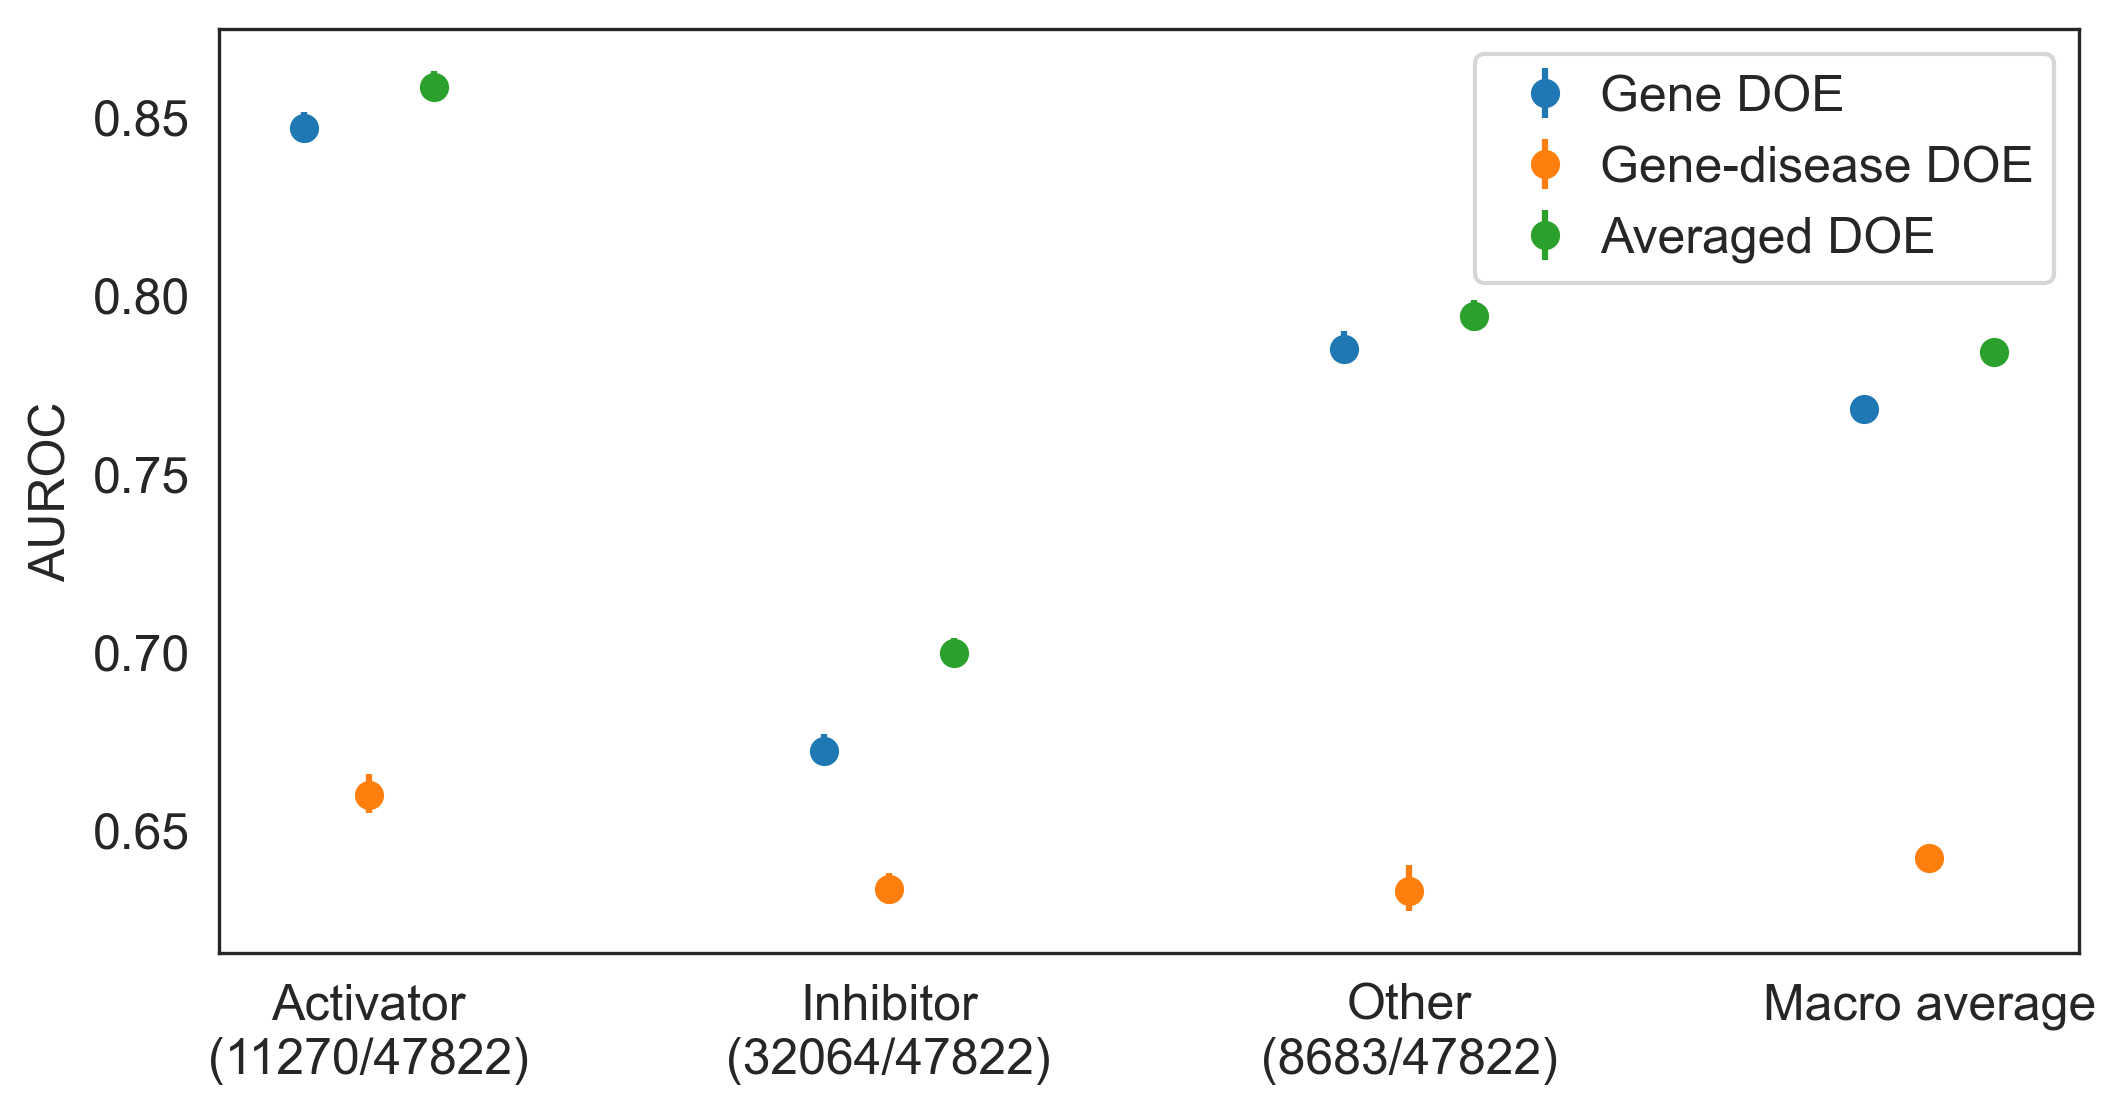

In [71]:
metrics = pd.read_pickle('./Training/Metrics/comp_metrics.pkl')
metrics = metrics.loc[metrics['subset'] == 'all']
metrics['model'] = metrics['model'].map({'doe':'Gene DOE',
                                         'pred':'Gene-disease DOE',
                                         'avg':'Averaged DOE'})
metrics['model'] = pd.Categorical(metrics['model'], ['Gene DOE','Gene-disease DOE','Averaged DOE'])

#####

drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    if True:
        drugs.loc[drugs[col] > 0, col] = 1
    if False:
        drugs.loc[drugs[col] == 0.5, col] = 1*0.732*0.548*0.580*0.911
        drugs.loc[drugs[col] == 1, col] = 1*0.732*0.548*0.580
        drugs.loc[drugs[col] == 2., col] = 1*0.732*0.548
        drugs.loc[drugs[col] == 3, col] = 1*0.732
        drugs.loc[drugs[col] == 4, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code','gene'],axis=1)

input = pd.read_pickle('./Training/input_extended.pkl')
input['ID'] = input['Code'] + '|' + input['gene']
input = input.drop(['Code','gene'],axis=1)
input = input.dropna(thresh=20, axis=1)
input = input.dropna(thresh=2,axis=0)

data = drugs.merge(input, on='ID')
n_ids = data['ID'].nunique()
n_neg = int(data['neg'].sum())
n_other = int(data['other'].sum())
n_pos = int(data['pos'].sum())

#####

res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auroc_other':f'Other\n({n_other}/{n_ids})',
                                   'auroc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=1, loc='upper right', columnspacing=0.1, handletextpad=0.1)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('AUROC')


Text(0, 0.5, 'AUROC')

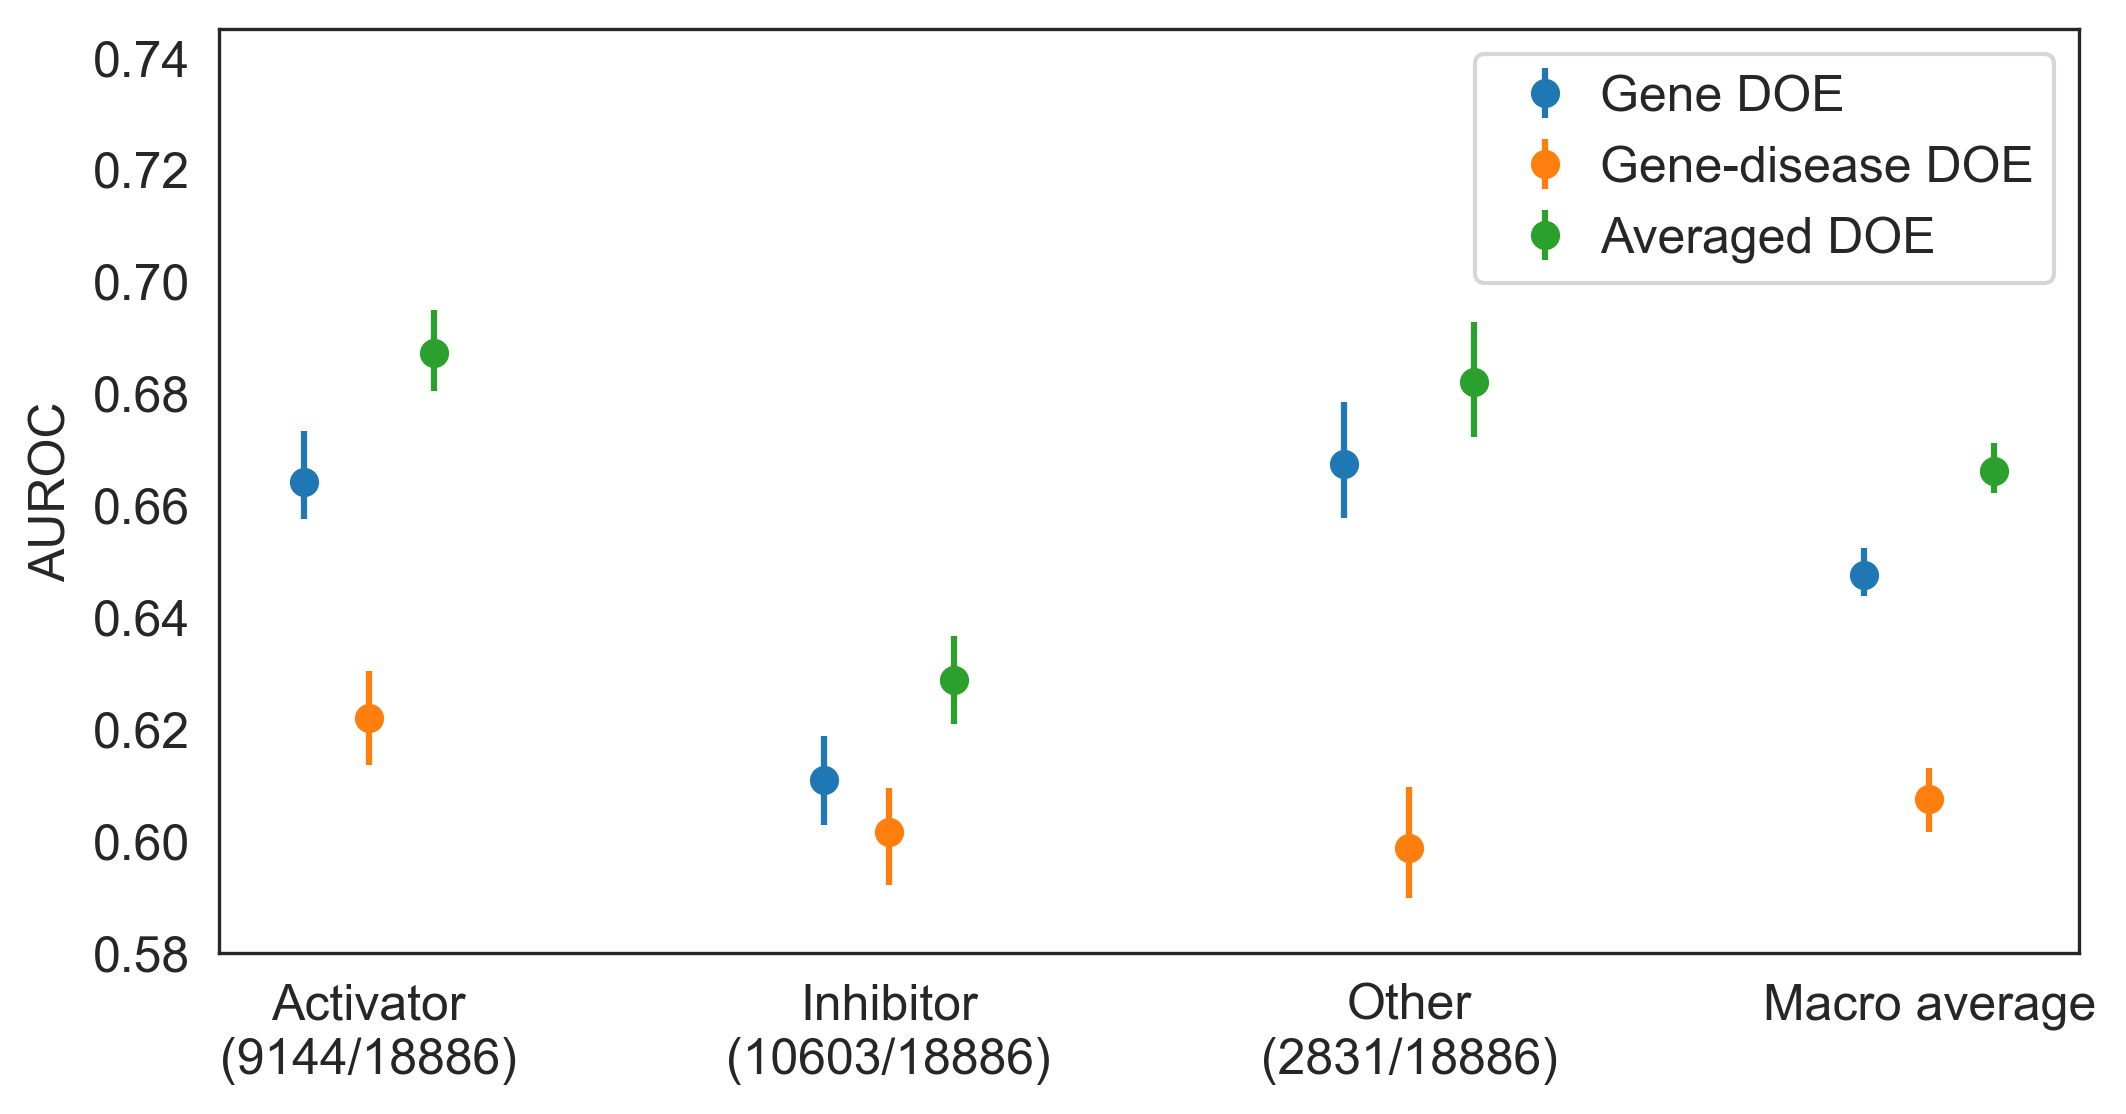

In [7]:
metrics = pd.read_pickle('./Training/Metrics/comp_metrics.pkl')
metrics = metrics.loc[metrics['subset'] == 'bd']
metrics['model'] = metrics['model'].map({'doe':'Gene DOE',
                                         'pred':'Gene-disease DOE',
                                         'avg':'Averaged DOE'})
metrics['model'] = pd.Categorical(metrics['model'], ['Gene DOE','Gene-disease DOE','Averaged DOE'])

#####

gda = pd.read_pickle('./OT/Final/gene_direction_all.pkl')
gda = gda.loc[(gda['neg'] == 1) & (gda['pos'] == 1)]['gene']

drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    if True:
        drugs.loc[drugs[col] > 0, col] = 1
    if False:
        drugs.loc[drugs[col] == 0.5, col] = 1*0.732*0.548*0.580*0.911
        drugs.loc[drugs[col] == 1, col] = 1*0.732*0.548*0.580
        drugs.loc[drugs[col] == 2., col] = 1*0.732*0.548
        drugs.loc[drugs[col] == 3, col] = 1*0.732
        drugs.loc[drugs[col] == 4, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.loc[drugs['gene'].isin(gda)]
drugs = drugs.drop(['Code','gene'],axis=1)

input = pd.read_pickle('./Training/input_extended.pkl')
input['ID'] = input['Code'] + '|' + input['gene']
input = input.drop(['Code','gene'],axis=1)
input = input.dropna(thresh=20, axis=1)
input = input.dropna(thresh=2,axis=0)

data = drugs.merge(input, on='ID')
n_ids = data['ID'].nunique()
n_neg = int(data['neg'].sum())
n_other = int(data['other'].sum())
n_pos = int(data['pos'].sum())

#####

res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auroc_other':f'Other\n({n_other}/{n_ids})',
                                   'auroc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=1, loc='upper right', columnspacing=0.1, handletextpad=0.1)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.ylim([0.58,0.745])
plt.xlabel('')
plt.ylabel('AUROC')


In [13]:
# Load and preprocess drug data
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg', 'other', 'pos']:
    drugs.loc[drugs[col] > 0, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code', 'gene'], axis=1)

# Load predictions
data = pd.read_csv(f'./Training/Predictions/all_holdout_predictions.csv').merge(drugs)
data['gene'] = data['ID'].str.split('|').str[1]

doe = pd.read_csv(f'./Training/Predictions/doe_all_holdout_predictions.csv')
doe = doe.set_axis(['gene', 'doe_neg', 'doe_other', 'doe_pos'], axis=1)
data = data.merge(doe)

data['pred_neg'] = (data['pred_neg'] - data['pred_neg'].mean()) / data['pred_neg'].std()
data['doe_neg'] = (data['doe_neg'] - data['doe_neg'].mean()) / data['doe_neg'].std()

res = []
X1 = sm.add_constant(data[['pred_neg', 'doe_neg']])
y1 = data['neg']
model1 = sm.Logit(y1, X1).fit(disp=0)

# Extract OR, 95% CI, and p-values
params = model1.params
conf = model1.conf_int()
conf.columns = ['2.5%', '97.5%']
pvalues = model1.pvalues

# Calculate OR and 95% CI for OR
or_values = np.exp(params)
ci_lower = np.exp(conf['2.5%'])
ci_upper = np.exp(conf['97.5%'])

# Store results in a DataFrame
rdf = pd.DataFrame({
    'OR': or_values,
    'CI_lower': ci_lower,
    'CI_upper': ci_upper,
    'p_value': pvalues
}).reset_index().rename(columns={'index': 'Variable'})

rdf = rdf.loc[rdf['Variable'] != 'const']
rdf['Variable'] = rdf['Variable'].map({'pred_neg':'Gene-disease DOE',
                                       'doe_neg':'Gene DOE'})

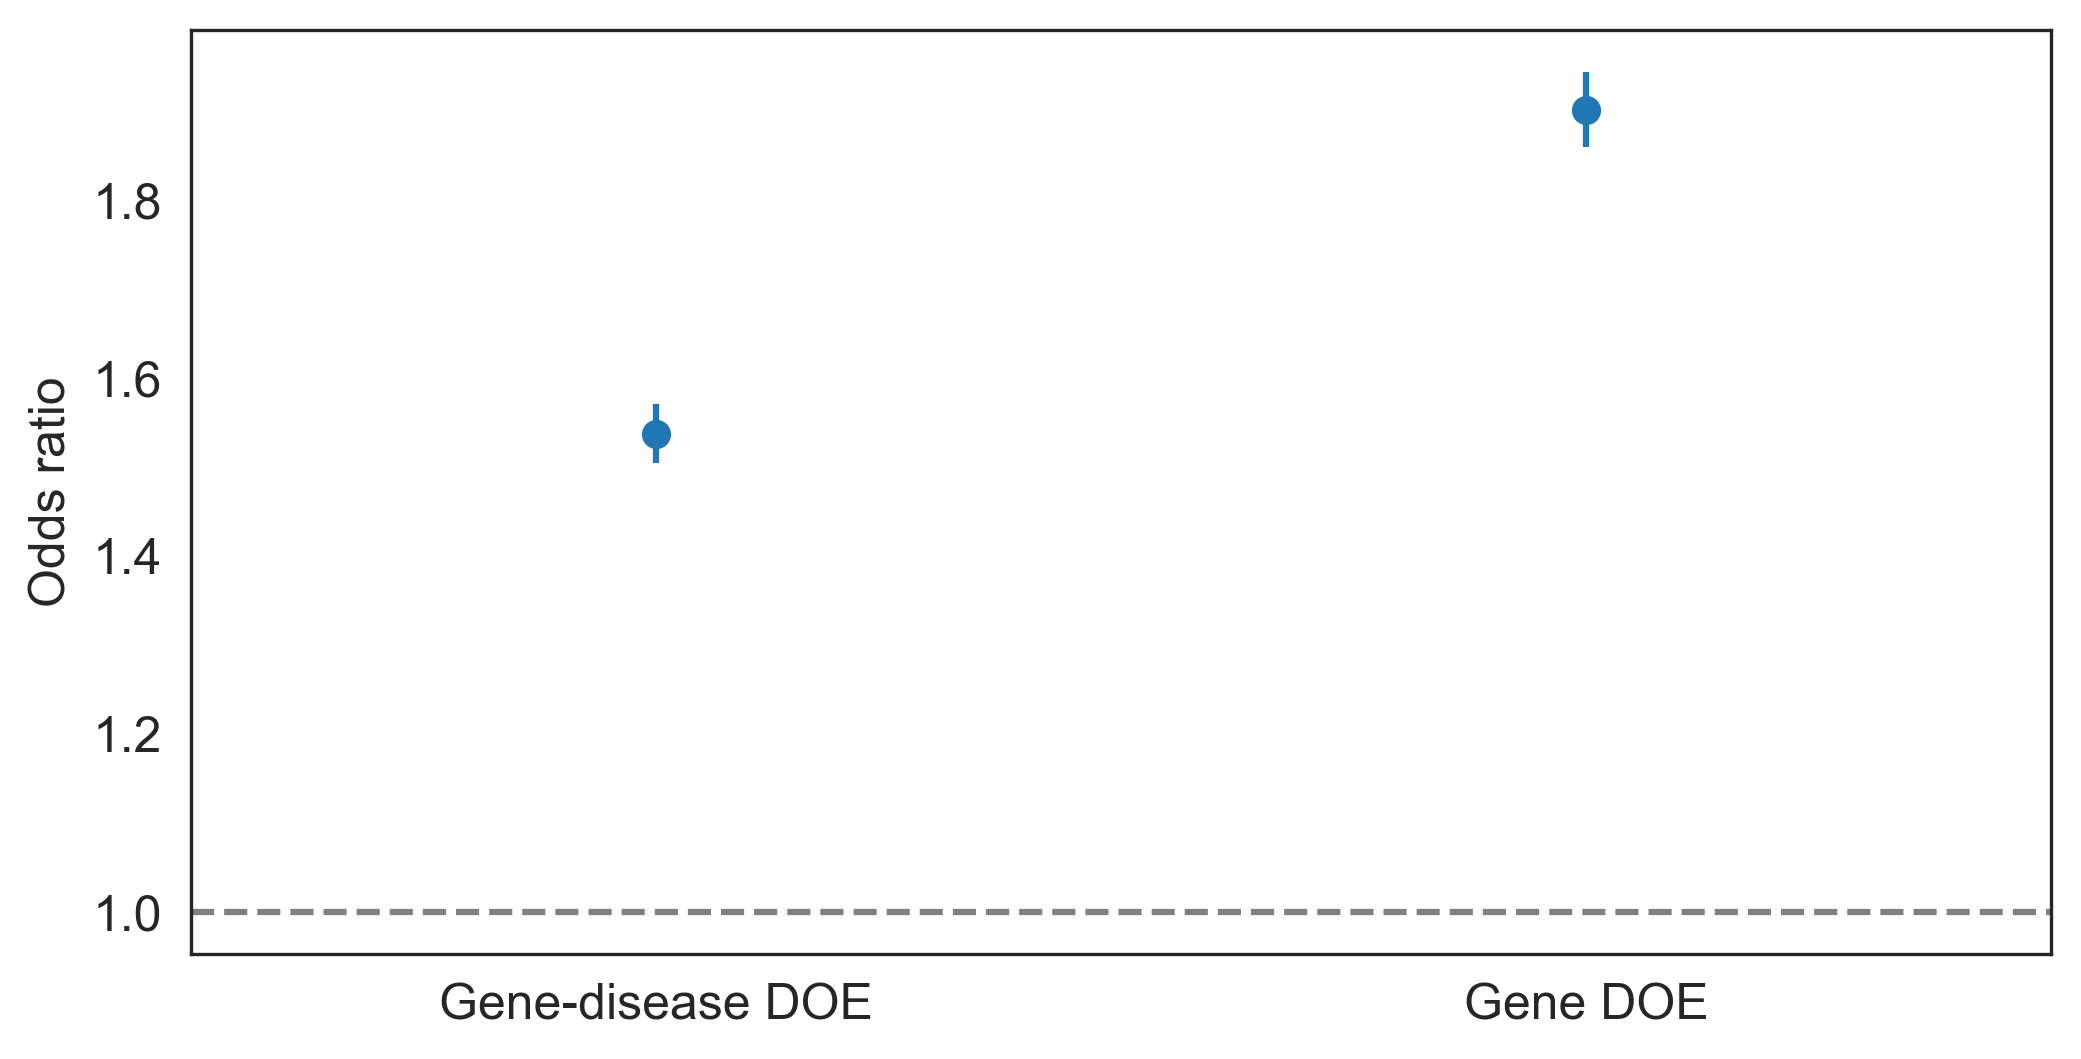

In [38]:
# Data
data = pd.DataFrame({
    'Variable': ['Gene-disease DOE', 'Gene DOE'],
    'OR': [1.536770, 1.901461],
    'CI_lower': [1.503943, 1.859947],
    'CI_upper': [1.570314, 1.943902]
})

# Compute error bars
yerr = [data['OR'] - data['CI_lower'], data['CI_upper'] - data['OR']]

# Plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
x_positions = range(len(data))

ax.errorbar(x_positions, data['OR'], yerr=yerr, fmt='o')
ax.set_xticks(x_positions)
ax.set_xticklabels(data['Variable'])
ax.set_ylabel("Odds ratio")
ax.axhline(y=1, linestyle='--', color='gray')

ax.set_xlim(min(x_positions)-0.5, max(x_positions)+0.5)

plt.show()